In [72]:
from collections import defaultdict
from pathlib import Path
import json
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV



TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def get_best_agent_metrics():
    best_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    specific_exp_dir = Path("../logs/specific")
    for exp_dir in specific_exp_dir.iterdir():


        
        returns = []
        for seed_dir in exp_dir.iterdir():
            if (seed_dir / "eval.jsonl").exists():
                metrics = json.loads((seed_dir / "eval.jsonl").read_text().split("\n")[0])
                returns.append(metrics["return"])
        if len(returns) == 0:
            continue
        task = None
        for k in best_agent_metrics:
            if k in exp_dir.name:
                task = k
                break
        
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        
        ctx_k_v_str = exp_dir.name.split("specific_")[1].split("_enc")[0]
        
        ctx_val = [default_0, default_1]
        for k_v in ctx_k_v_str.split("_"):
            k, v = k_v.split("-")
            v = float(v)
            k = int(k)
            ctx_val[int(k)] = v
        best_agent_metrics[task][(ctx_val[0], ctx_val[1])] = returns
    return best_agent_metrics


In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_best_agent_metrics(best_agent_metrics, save_dir):

    for task in best_agent_metrics:
        x = []
        y = []
        c = []
        for ctx_0_value, ctx_1_value in best_agent_metrics[task]:
            x.append(ctx_0_value)
            y.append(ctx_1_value)
            c.append(np.mean(best_agent_metrics[task][(ctx_0_value, ctx_1_value)]))
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]

        df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
        df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
        
        # sort the rows descending
        df = df.sort_index(ascending=False)

        
        # darker colors for higher values, red color map
        ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f")

        # Title should be task - modality - context_name
        # bold the context name
        title = f"{task} - vec - specific context mean return"
        save_path = save_dir / f"{task}_vec_best.pdf"
        plt.title(title)
        plt.savefig(save_path)
        plt.pause(0.1)



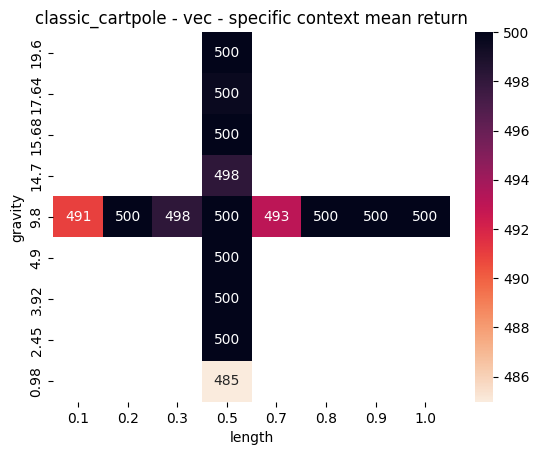

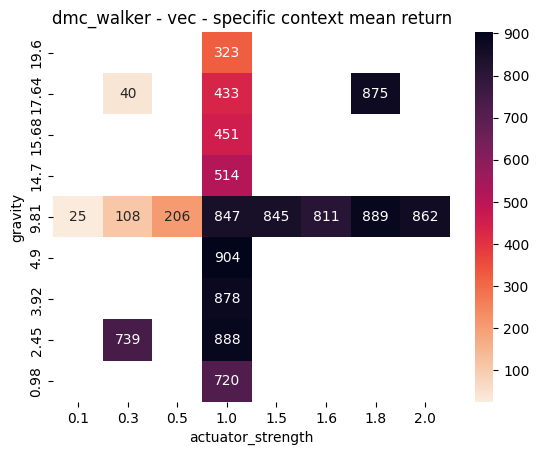

In [74]:
best_agent_metrics = get_best_agent_metrics()
save_dir = Path("./plots/")
plot_best_agent_metrics(best_agent_metrics, save_dir)

In [70]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def plot_violin_plots(task, train_setting, context_idx, modality, save_dir, log_dir, only_decode_ctx, best_agent_metrics, t_step="50k"):
    train_setting_full = "default" if train_setting == "default" else f"{train_setting}_{context_idx}"
    
    experiments = [
        log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}", 
        log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}{'_ctx' if not only_decode_ctx else ''}_dec_{modality}_ctx_{t_step}" 
    ] 
    modality = "vector" if modality == "obs" else "pixel"

    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    data = {
        "context_val": [],
        "input": [],
        "return": [],
    }
    ctx_encoding = 'enc_dec' if not only_decode_ctx else 'dec'
    seeds = 0
    for exp_path in experiments:
        experiment = exp_path.name
        if "ctx" not in experiment:
            inp = "no_ctx"
        else:
            inp = f"{ctx_encoding}_ctx"
        for seed_path in exp_path.iterdir():
            eval_file = seed_path / "eval.jsonl"
            if not eval_file.exists():
                continue
            seeds += 1
            with eval_file.open() as f:
                lines = f.readlines()
            lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
            for line in lines:
                if context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0:
                    ctx_value = line['ctx']["context"][context_name]
                    ret = float(line['return'])
                    data["context_val"].append(ctx_value)
                    data["input"].append(inp)
                    data["return"].append(ret)
    df = pd.DataFrame.from_dict(data)
    env = _TASK2ENV[task]

    default_context_val = env.get_default_context()[context_name]
    if train_setting == "default":
        interpolate_range = [default_context_val, default_context_val]
        split = False
        hue = None
        df = df[df["input"] == "no_ctx"]
        save_path = save_dir / f"{task}_{context_name}_{train_setting}_{modality}.pdf"
    else:
        interpolate_range = _TASK2CONTEXTS[task][context_idx]["train_range"]
        split = True
        hue = "input"
        save_path = save_dir / f"{task}_{context_name}_{train_setting}_{modality}_{ctx_encoding}_ctx.pdf"
    
    other_ctx_id = 1 - context_idx
    other_ctx_name = _TASK2CONTEXTS[task][other_ctx_id]["context"]
    other_default = env.get_default_context()[other_ctx_name]
    best_x = []
    best_y = []
    for ctx_val in best_agent_metrics[task]:
        if ctx_val[other_ctx_id] == other_default:
            best_x.append(ctx_val[context_idx])
            best_y.append(np.mean(best_agent_metrics[task][ctx_val]))
    plt.figure(figsize=(20,15))
    plt.scatter(best_x, best_y, color='r', label="best agent")
    sns.violinplot(data=df, x="context_val", y="return", hue=hue, split=split, cut=0, native_scale=True, density_norm="width", width=0.5)
    plt.xlabel(context_name)
    # show all x ticks
    plt.xticks(df["context_val"].unique())
    if interpolate_range[0] == interpolate_range[1]:
        # draw a vertical line at the context value
        plt.axvline(interpolate_range[0], color='g', linestyle='--')
        # add legend for the line
    else:
        # in the interpolate range, set the background color to green
        plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='g', alpha=0.1)
        # add legend for the background
    # set the y axis to go from 0 to max return
    plt.ylim(0, TASK2MaxReturn[task] + 10)    

    # Title should be task - modality - context_name
    # bold the context name
    title = f"{task} - {modality}"
    plt.title(title)
    plt.savefig(save_path)
    if seeds != 10:
        print(f"not enough seeds - {title} - {seeds}")        

not enough seeds - classic_cartpole - vector - 9
not enough seeds - classic_cartpole - vector - 9
not enough seeds - dmc_walker - pixel - 9


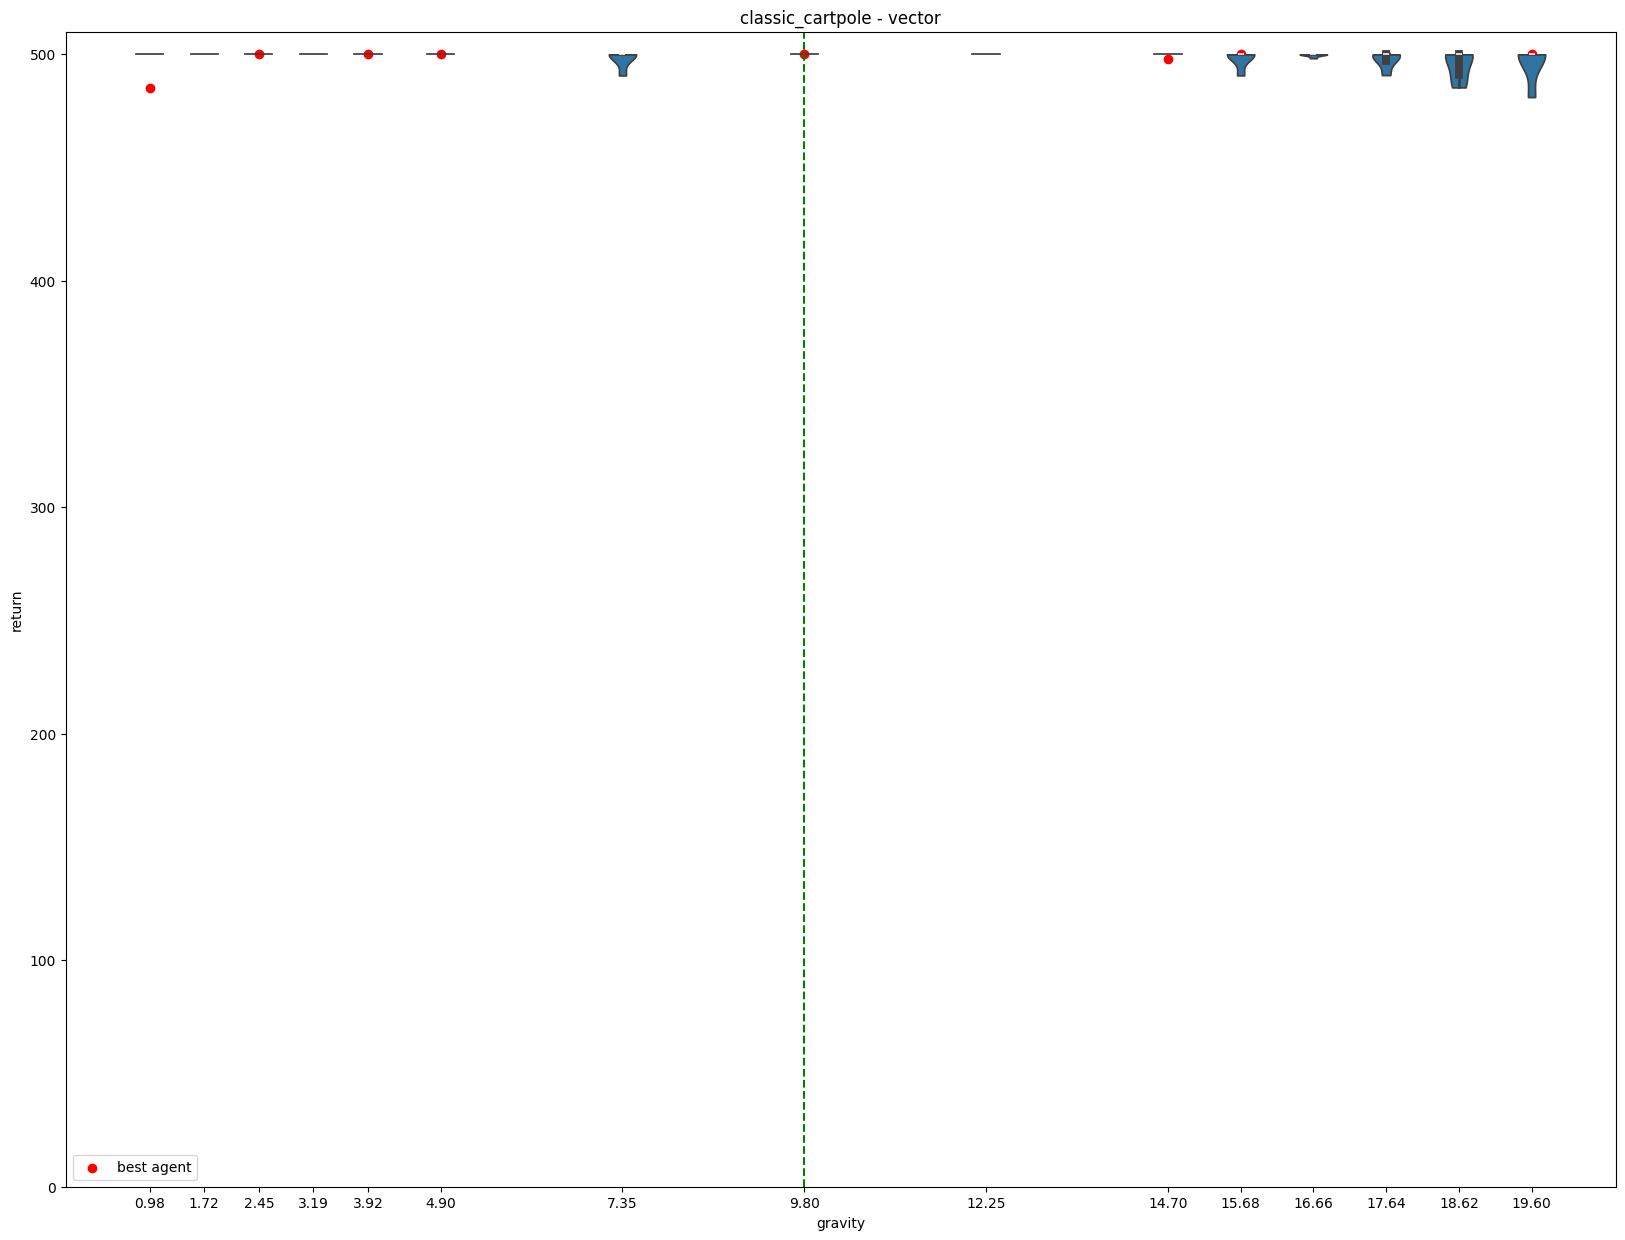

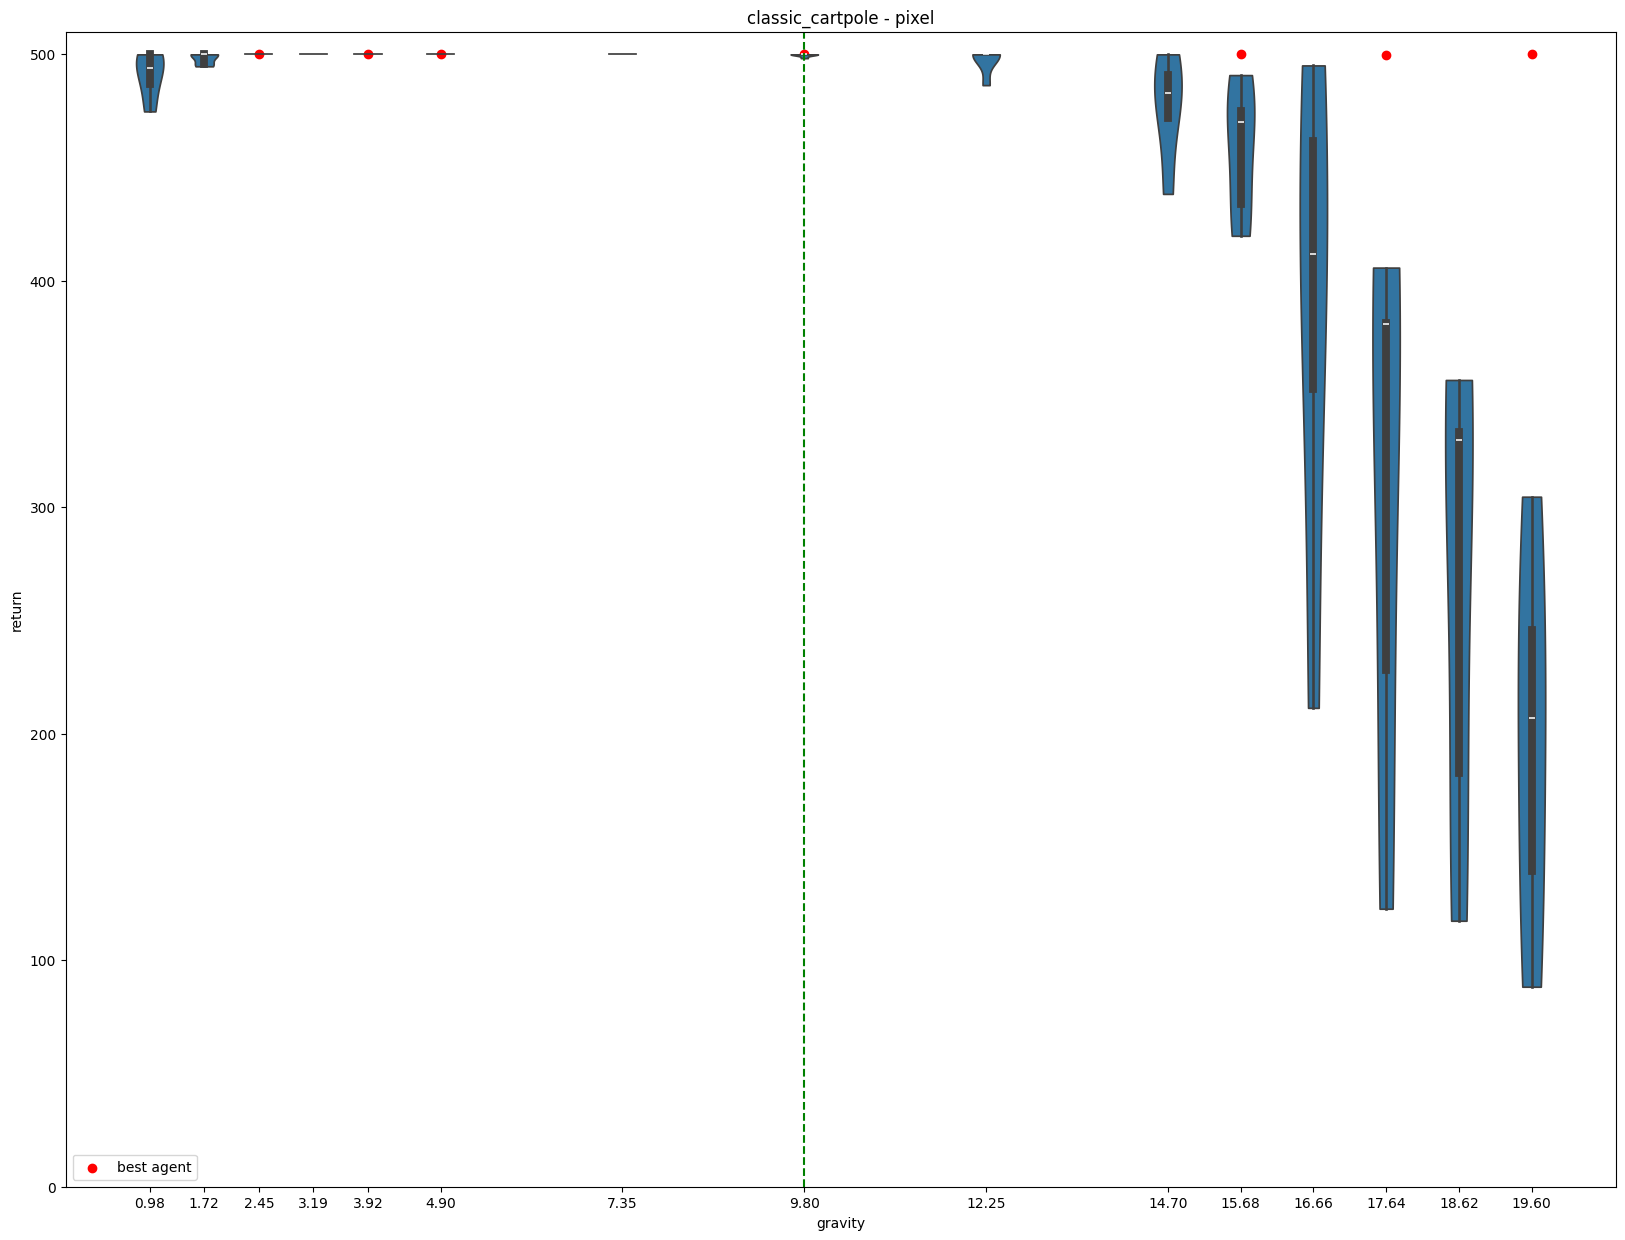

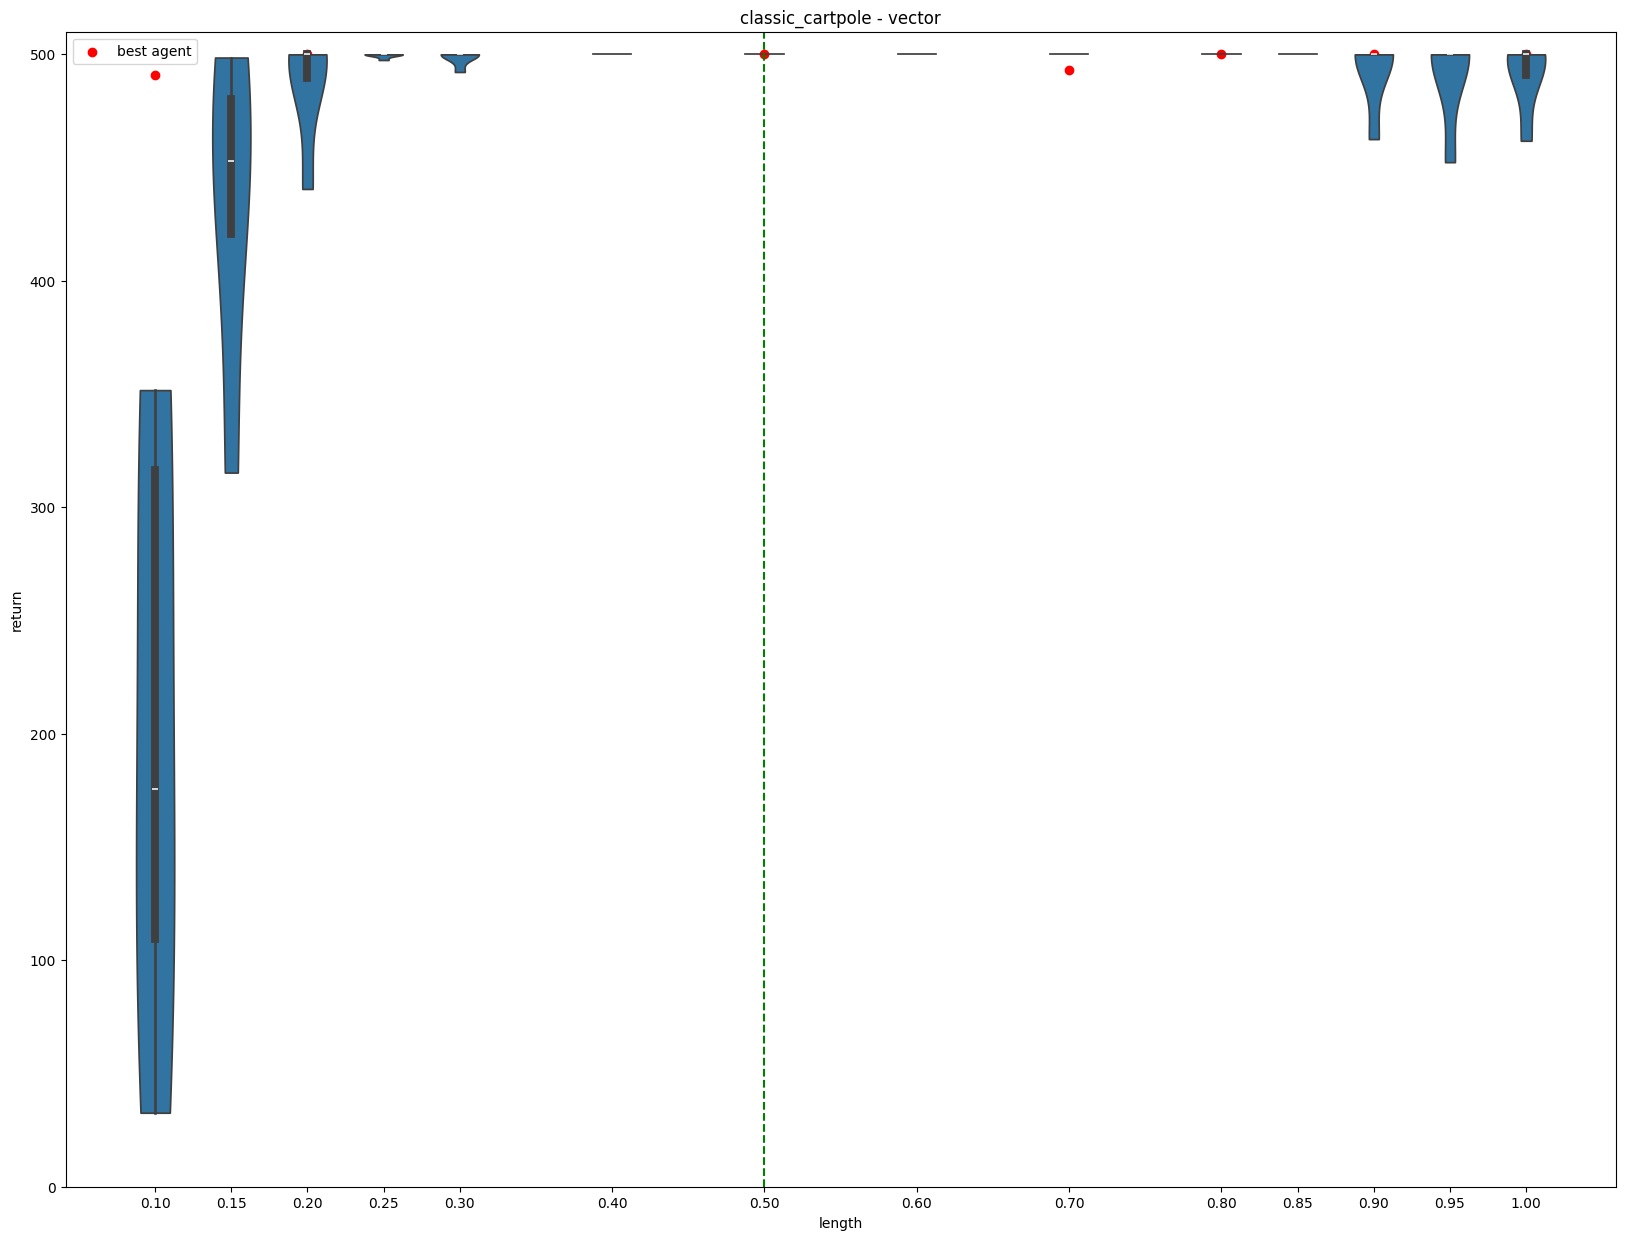

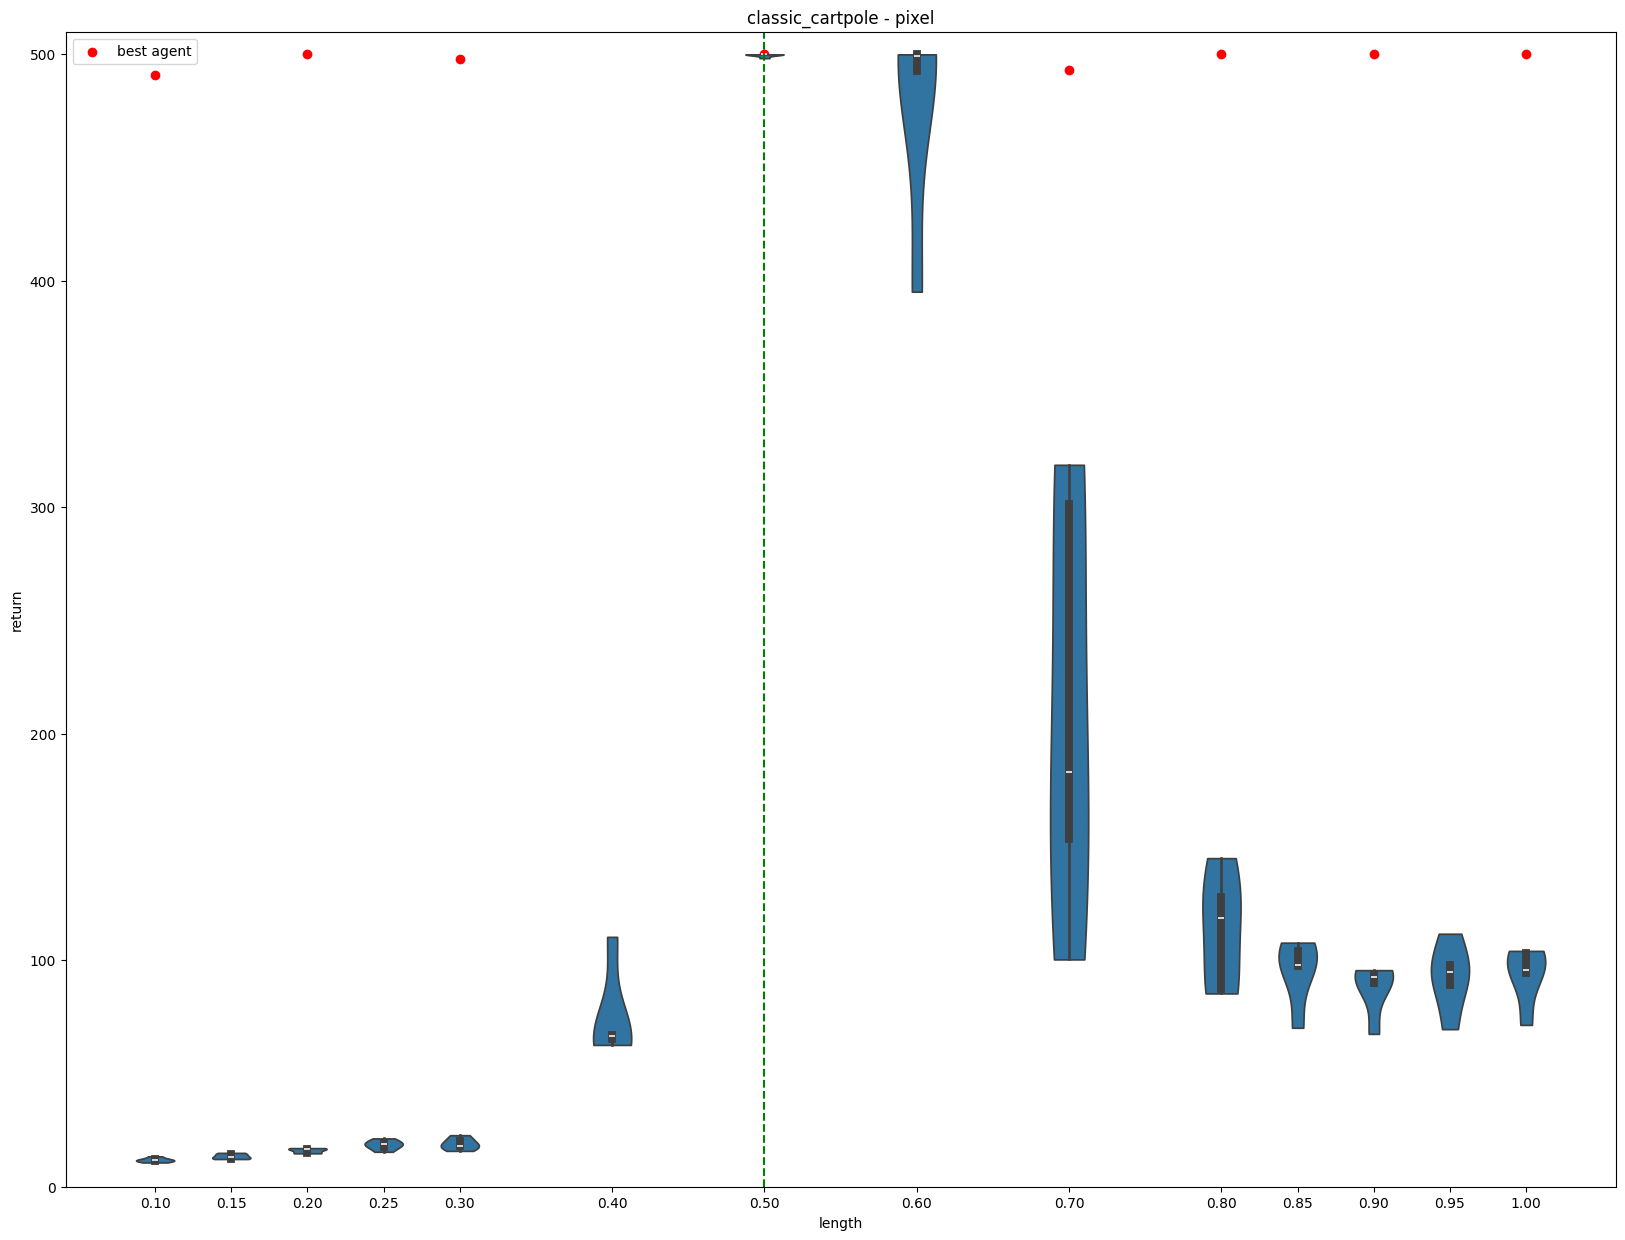

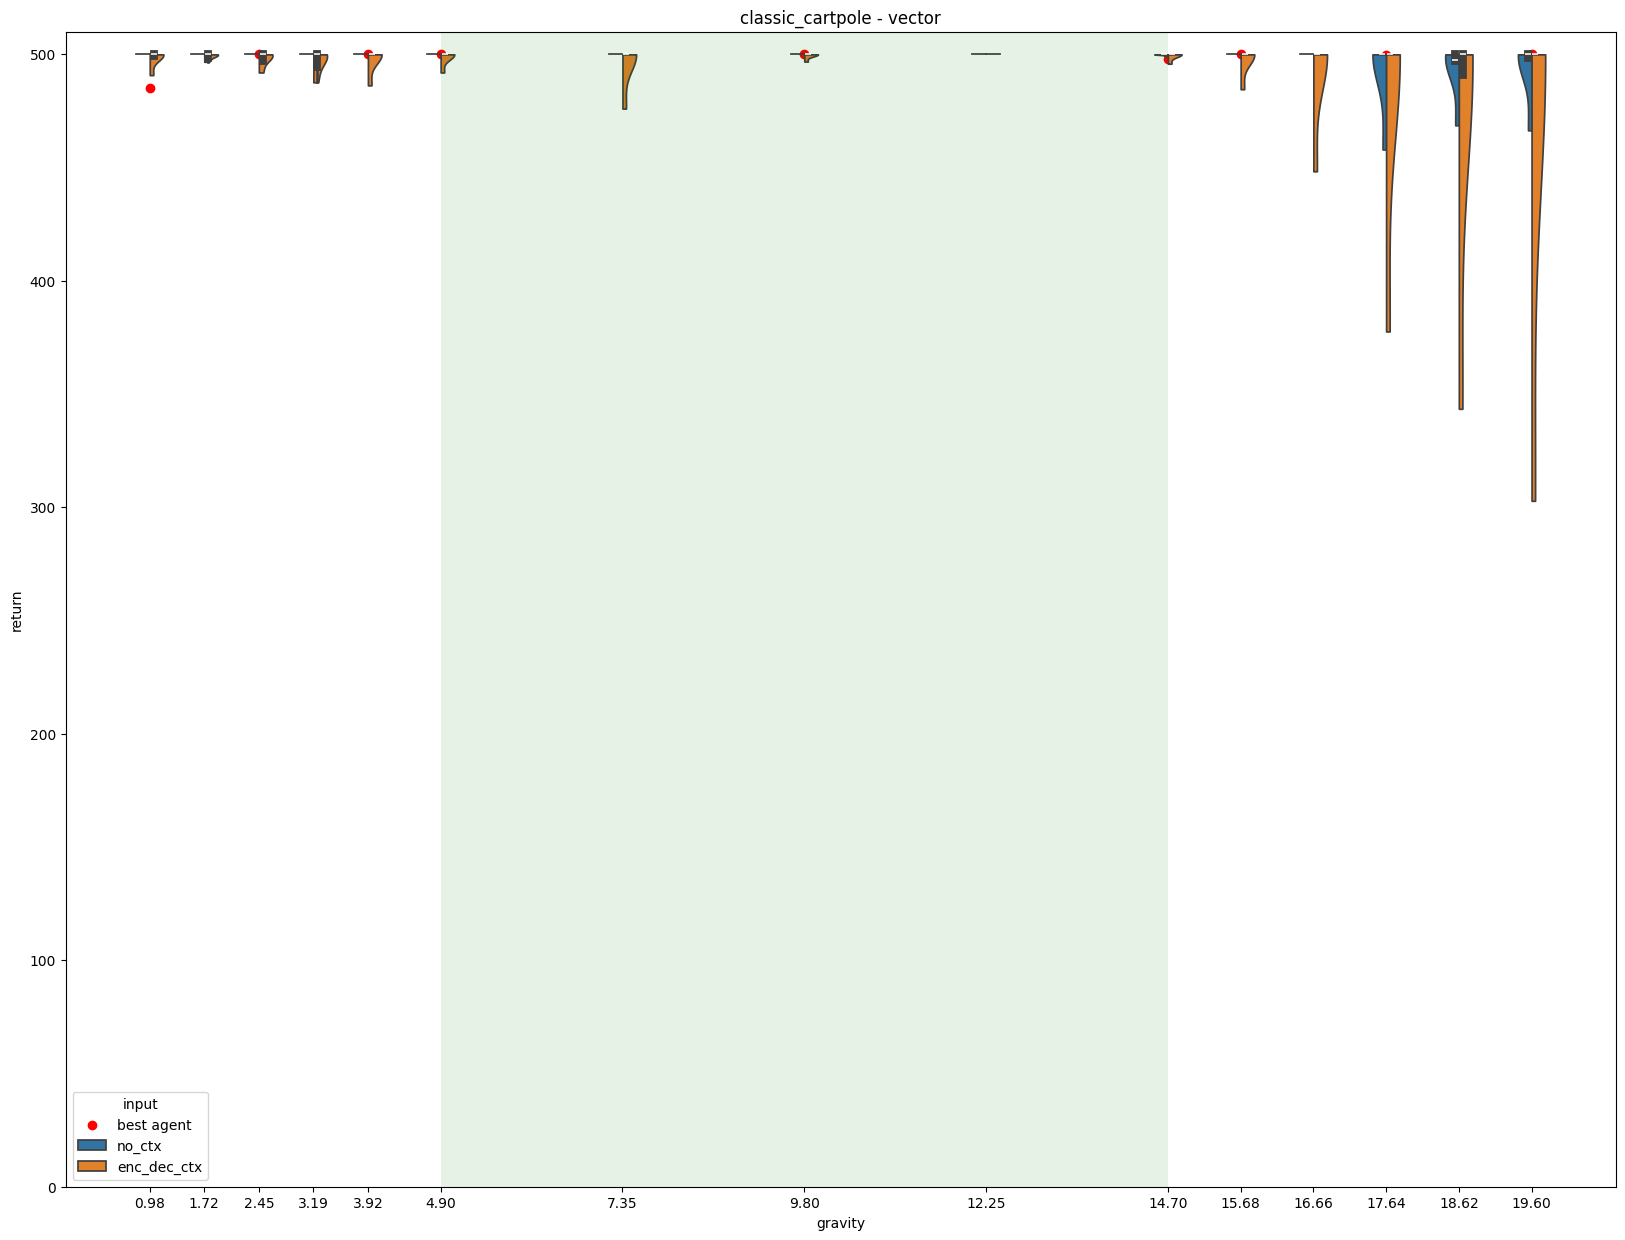

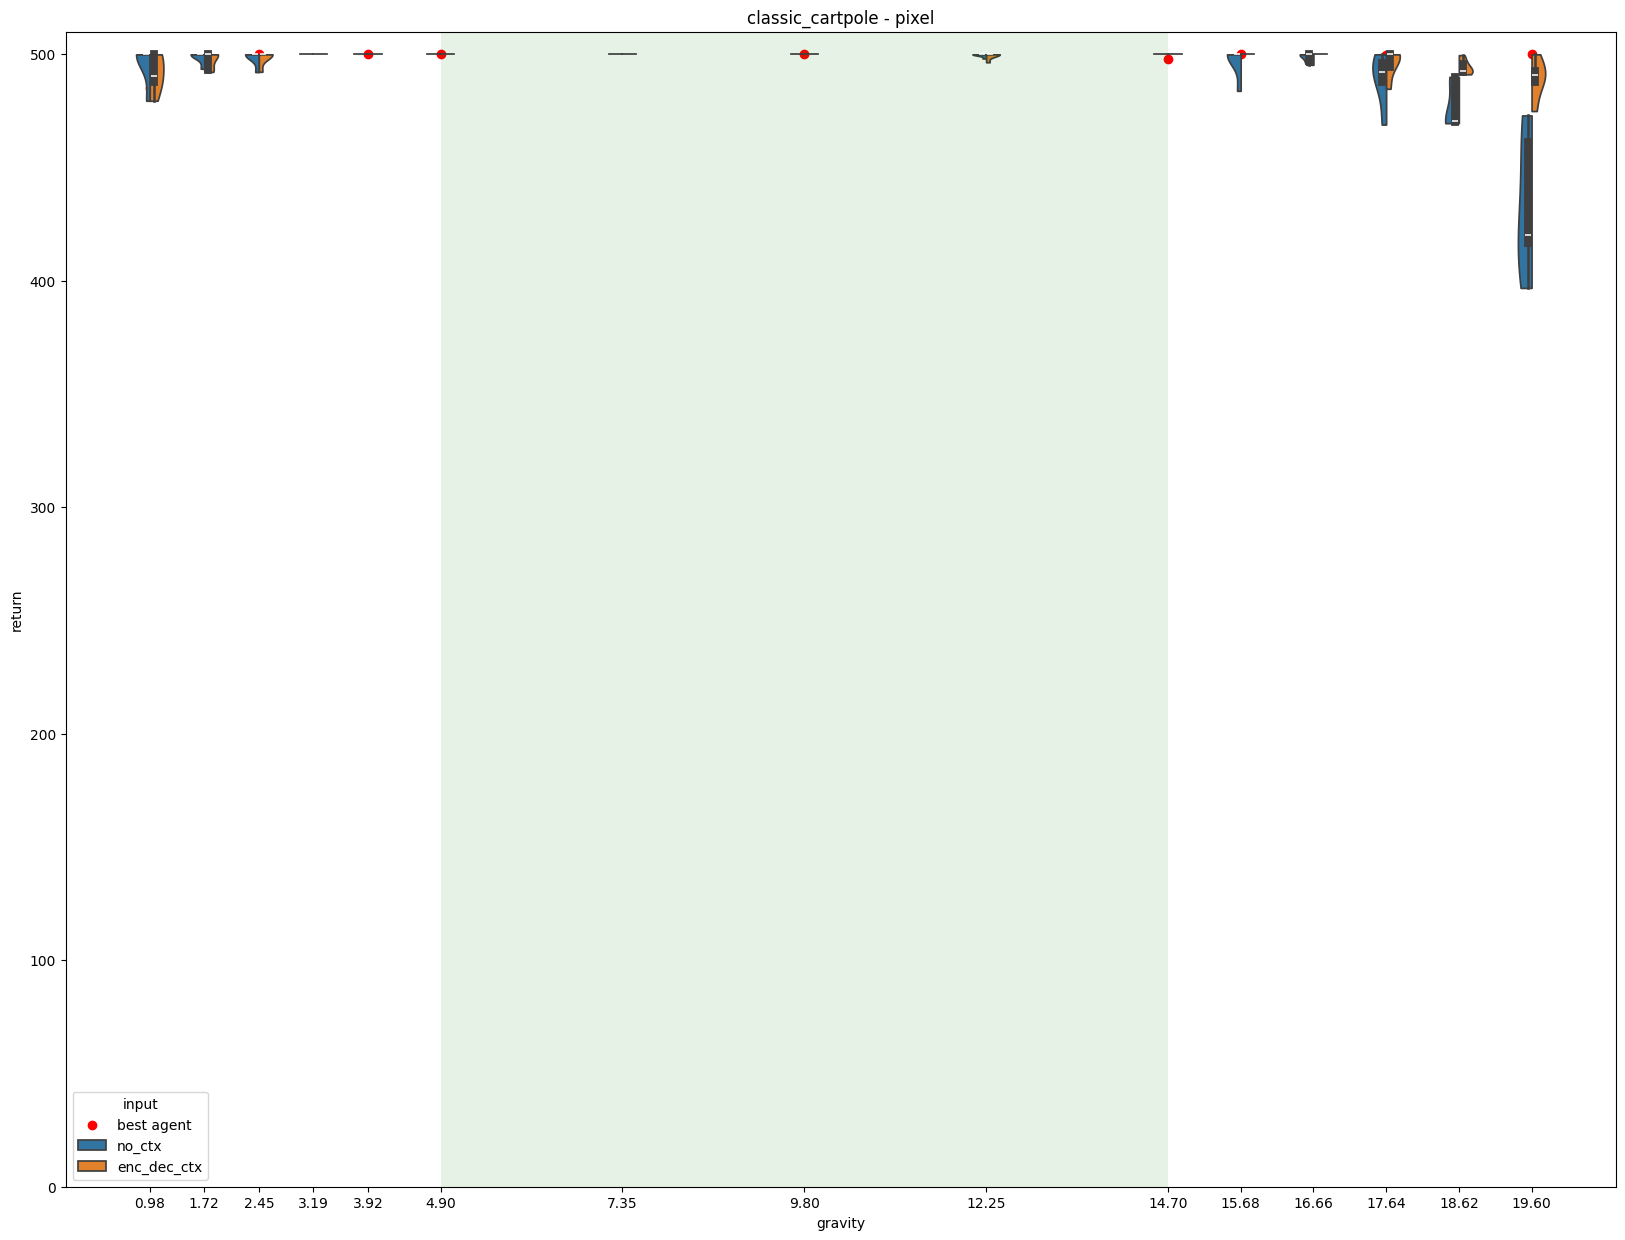

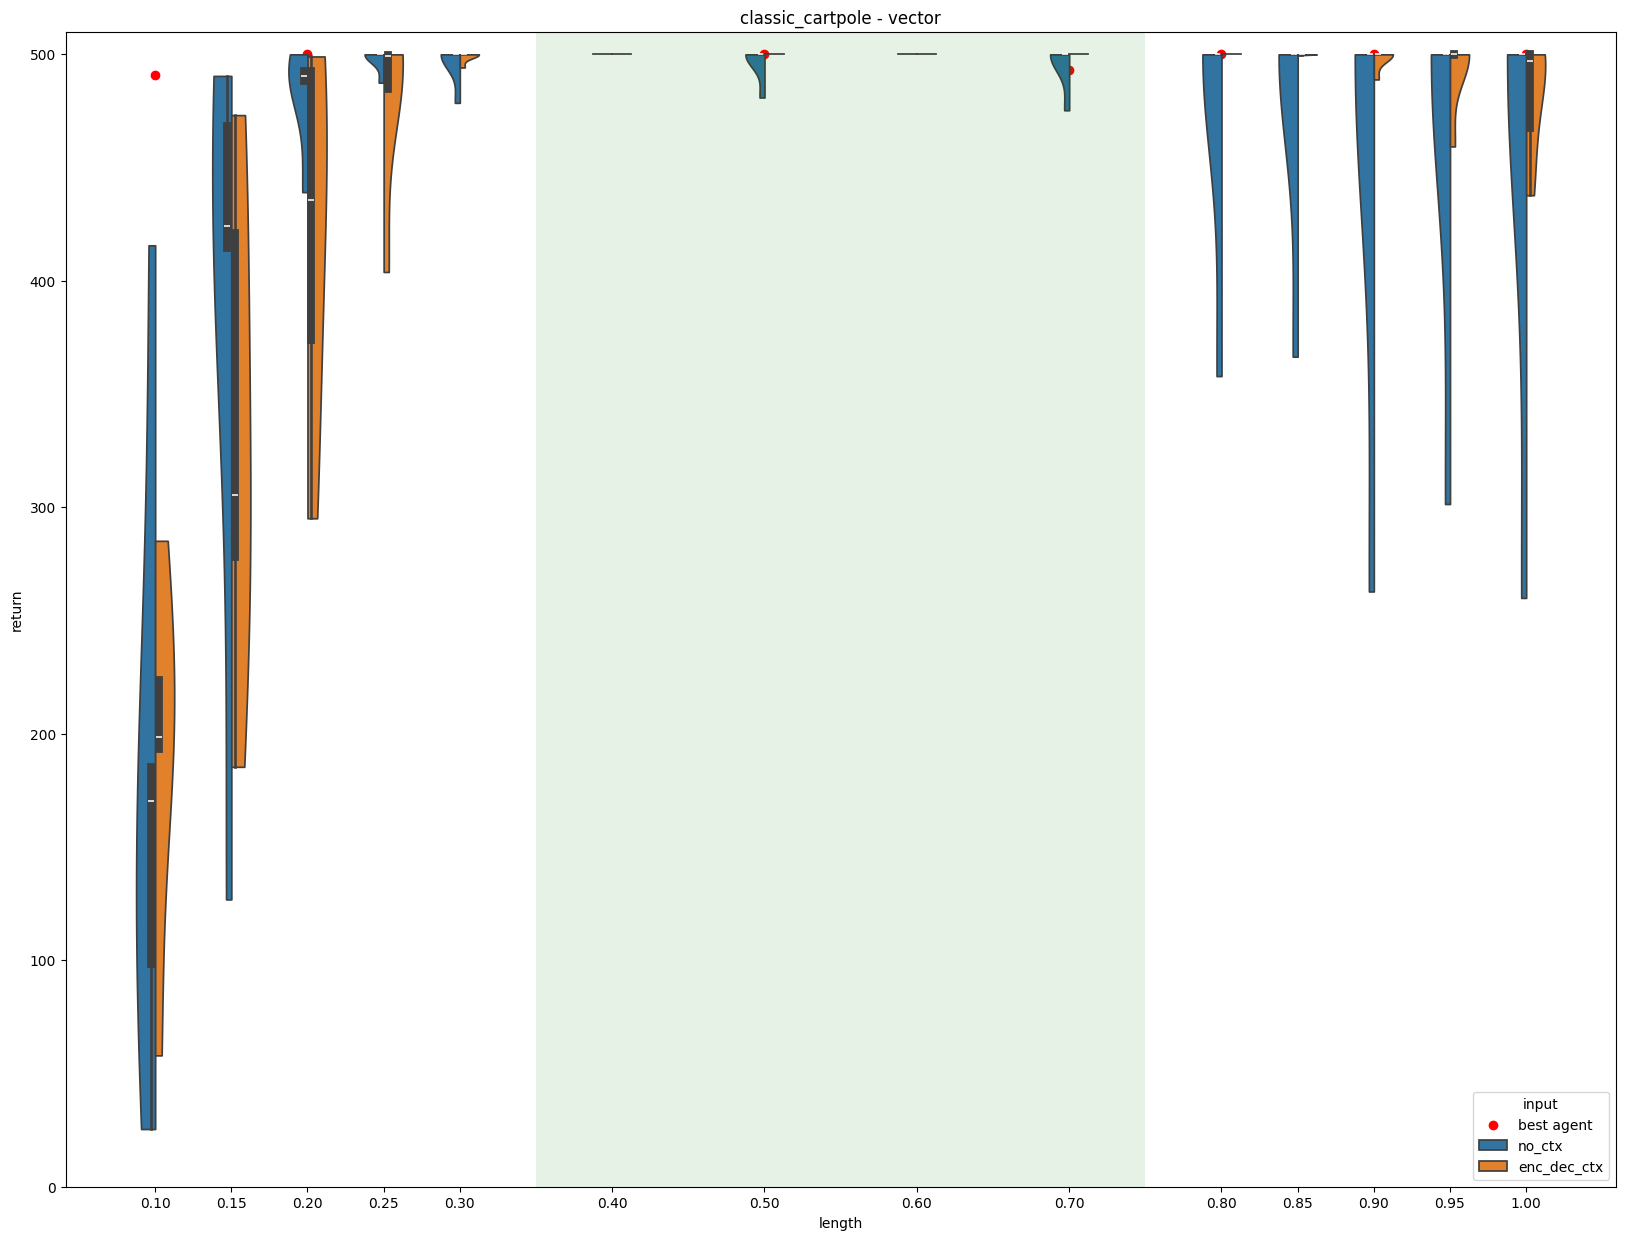

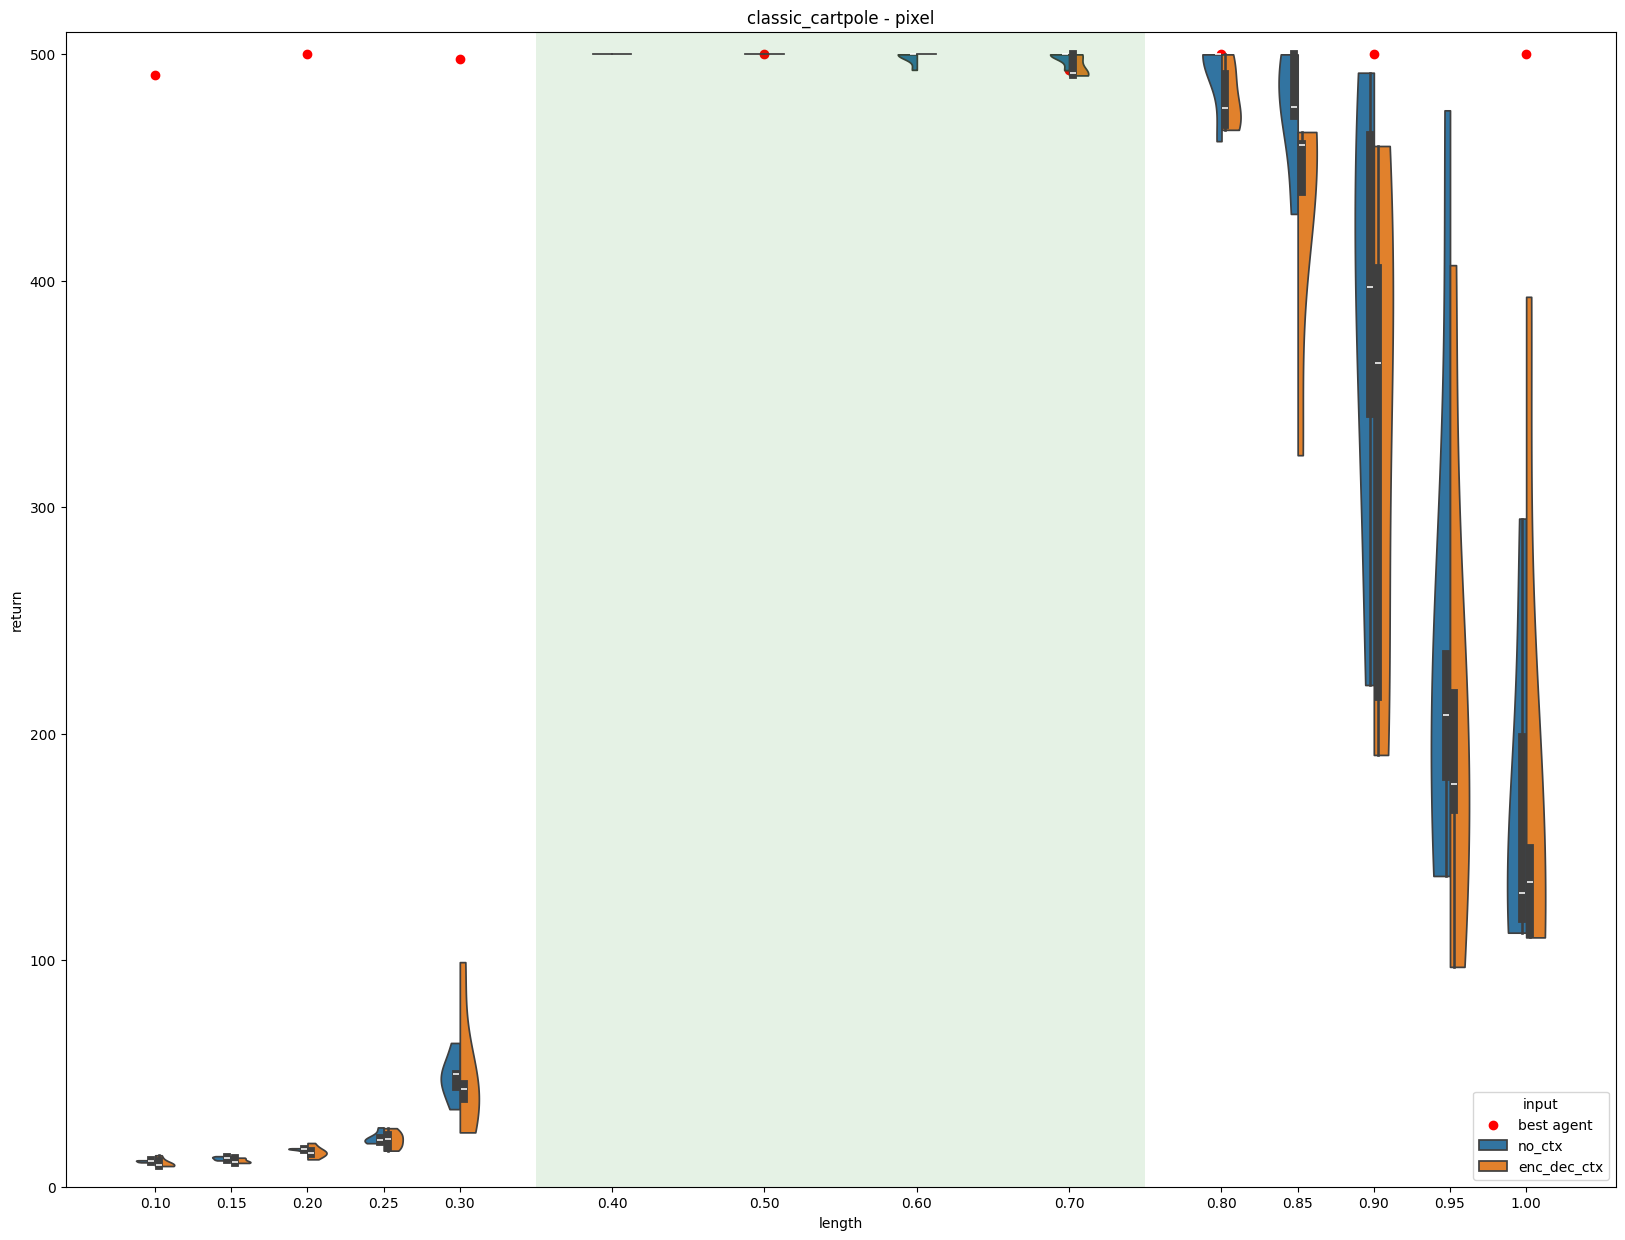

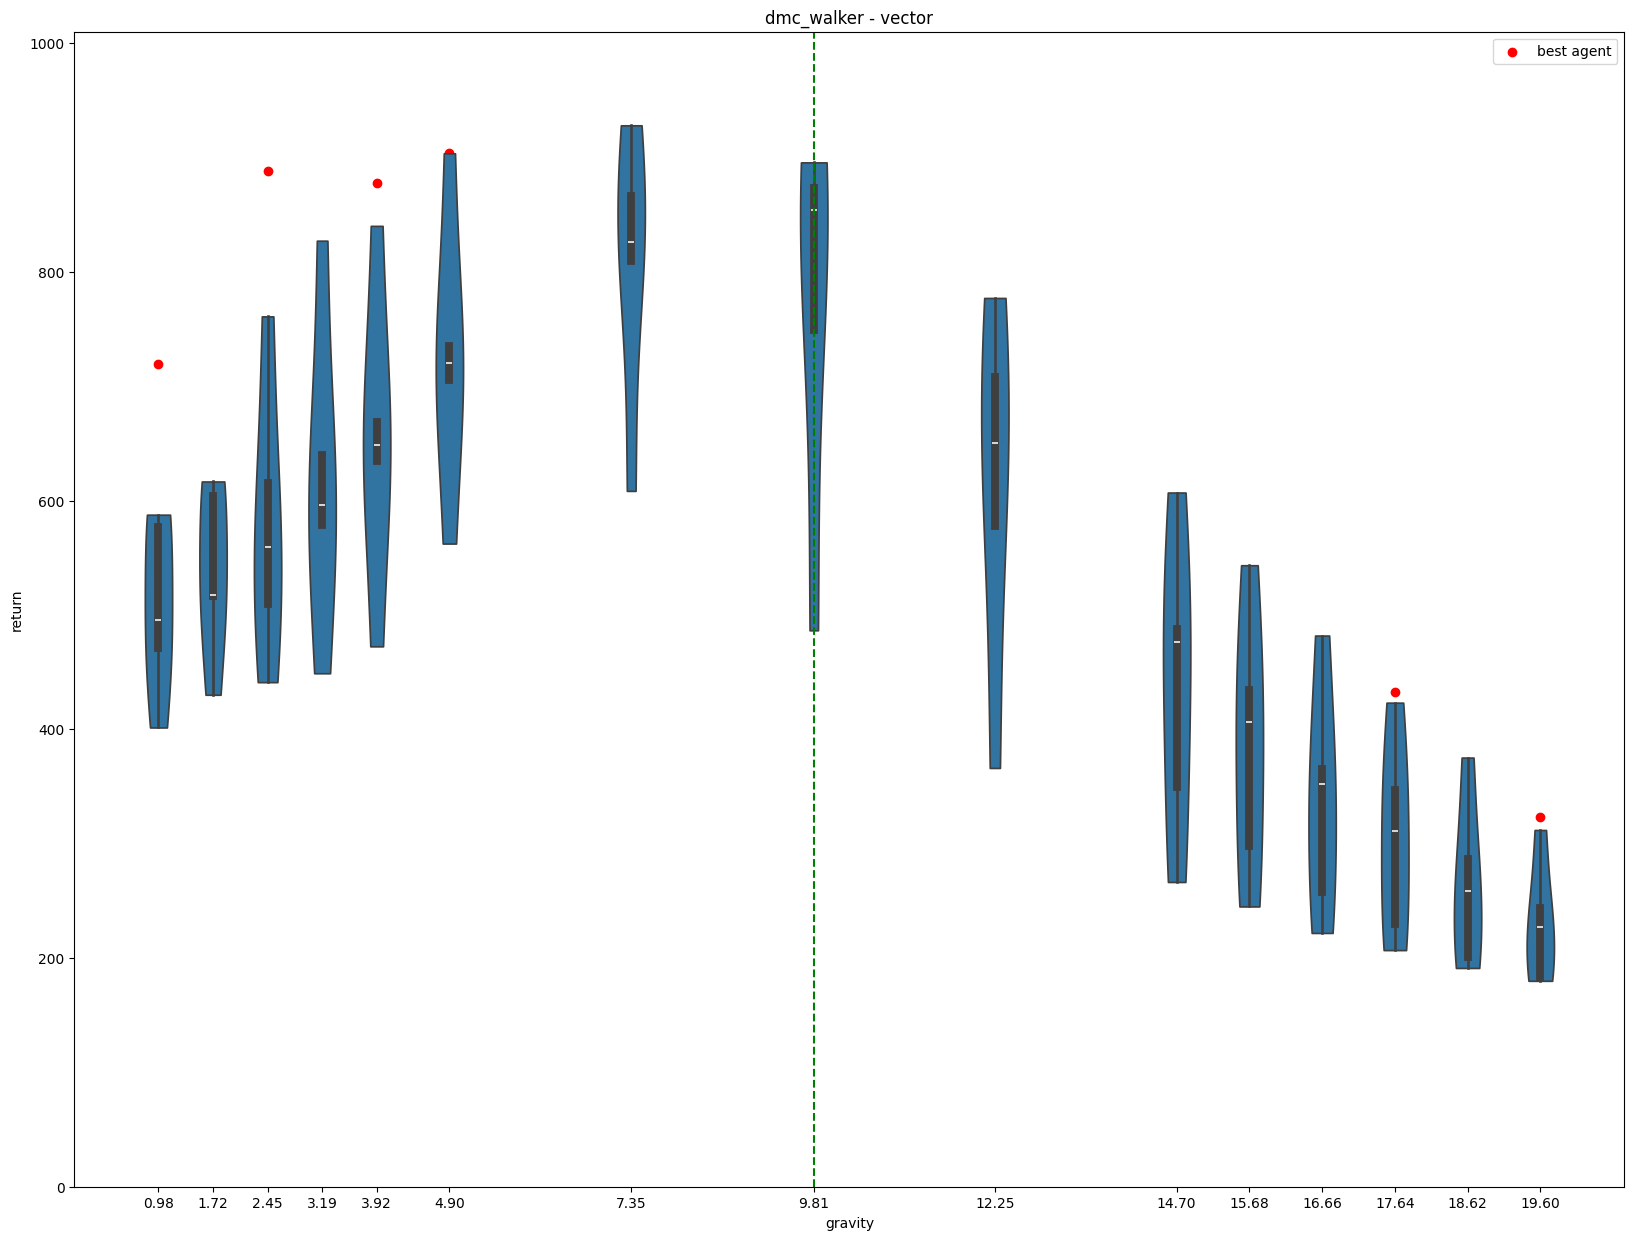

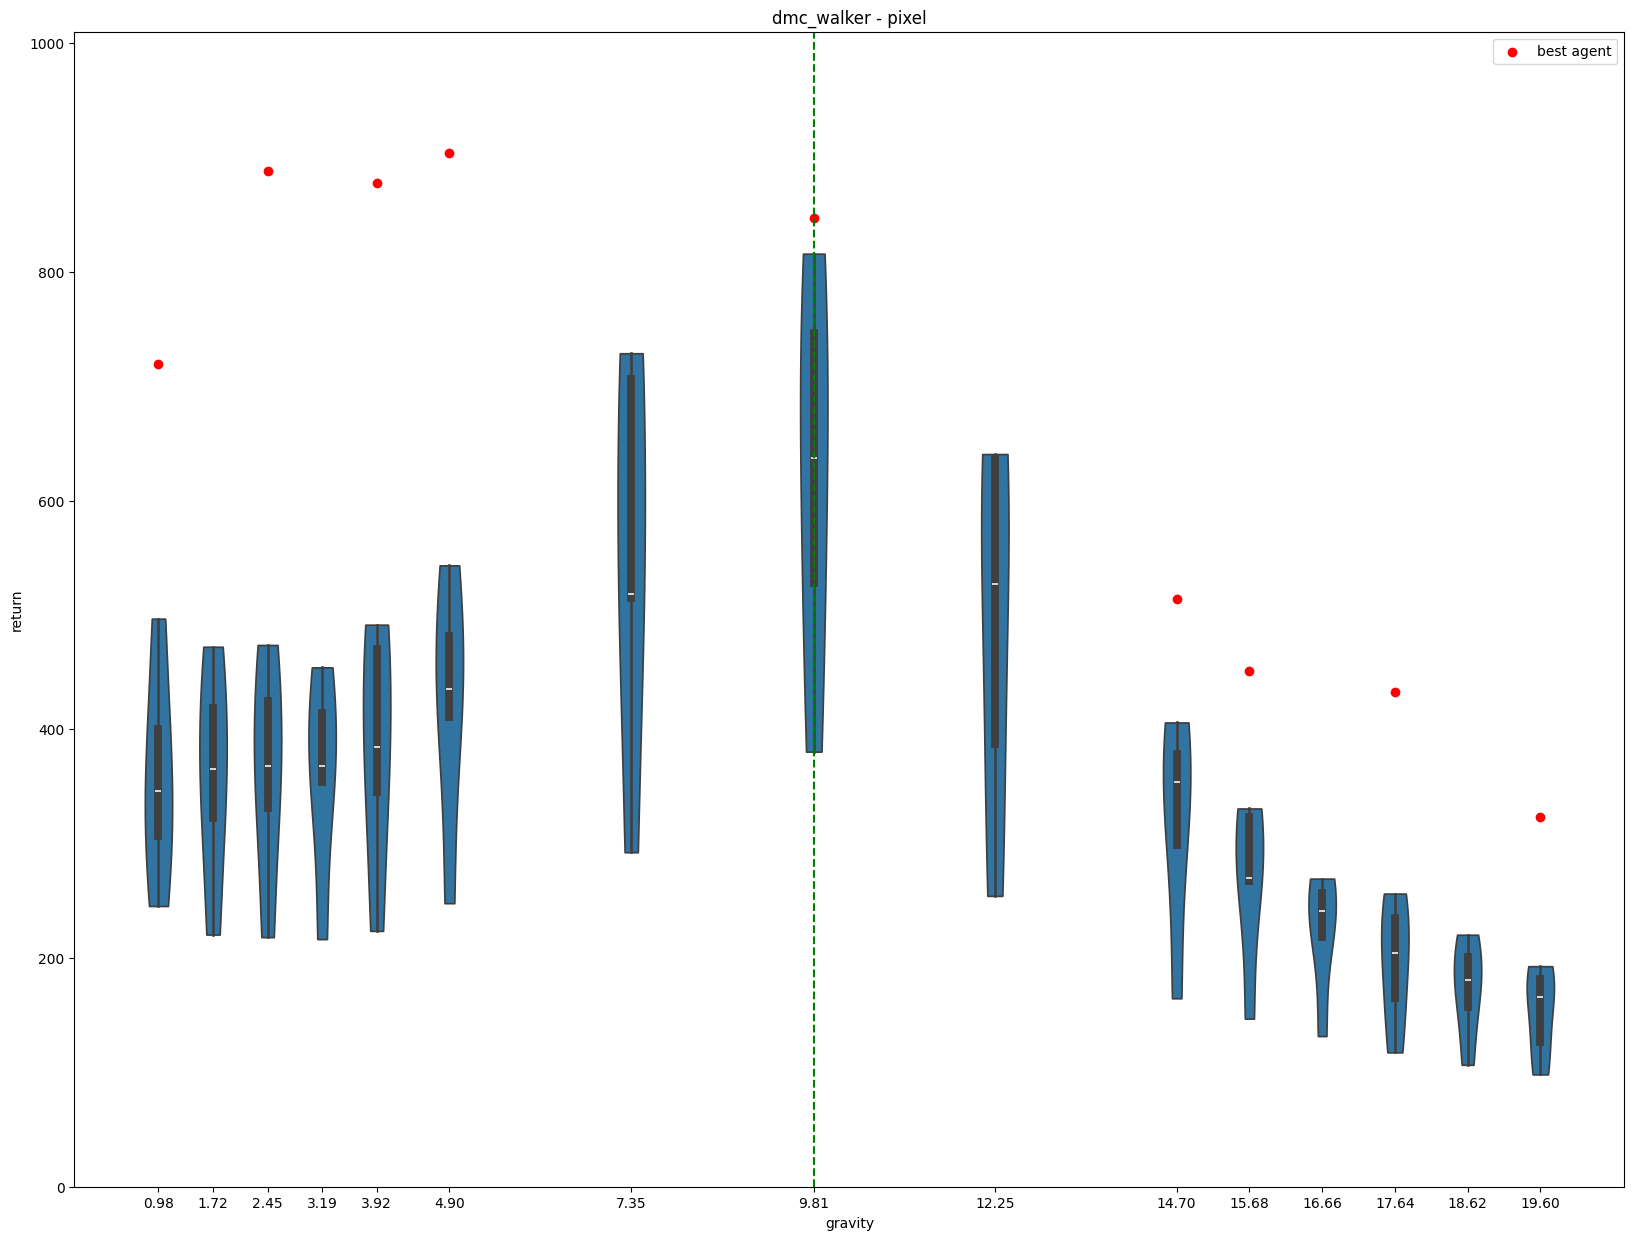

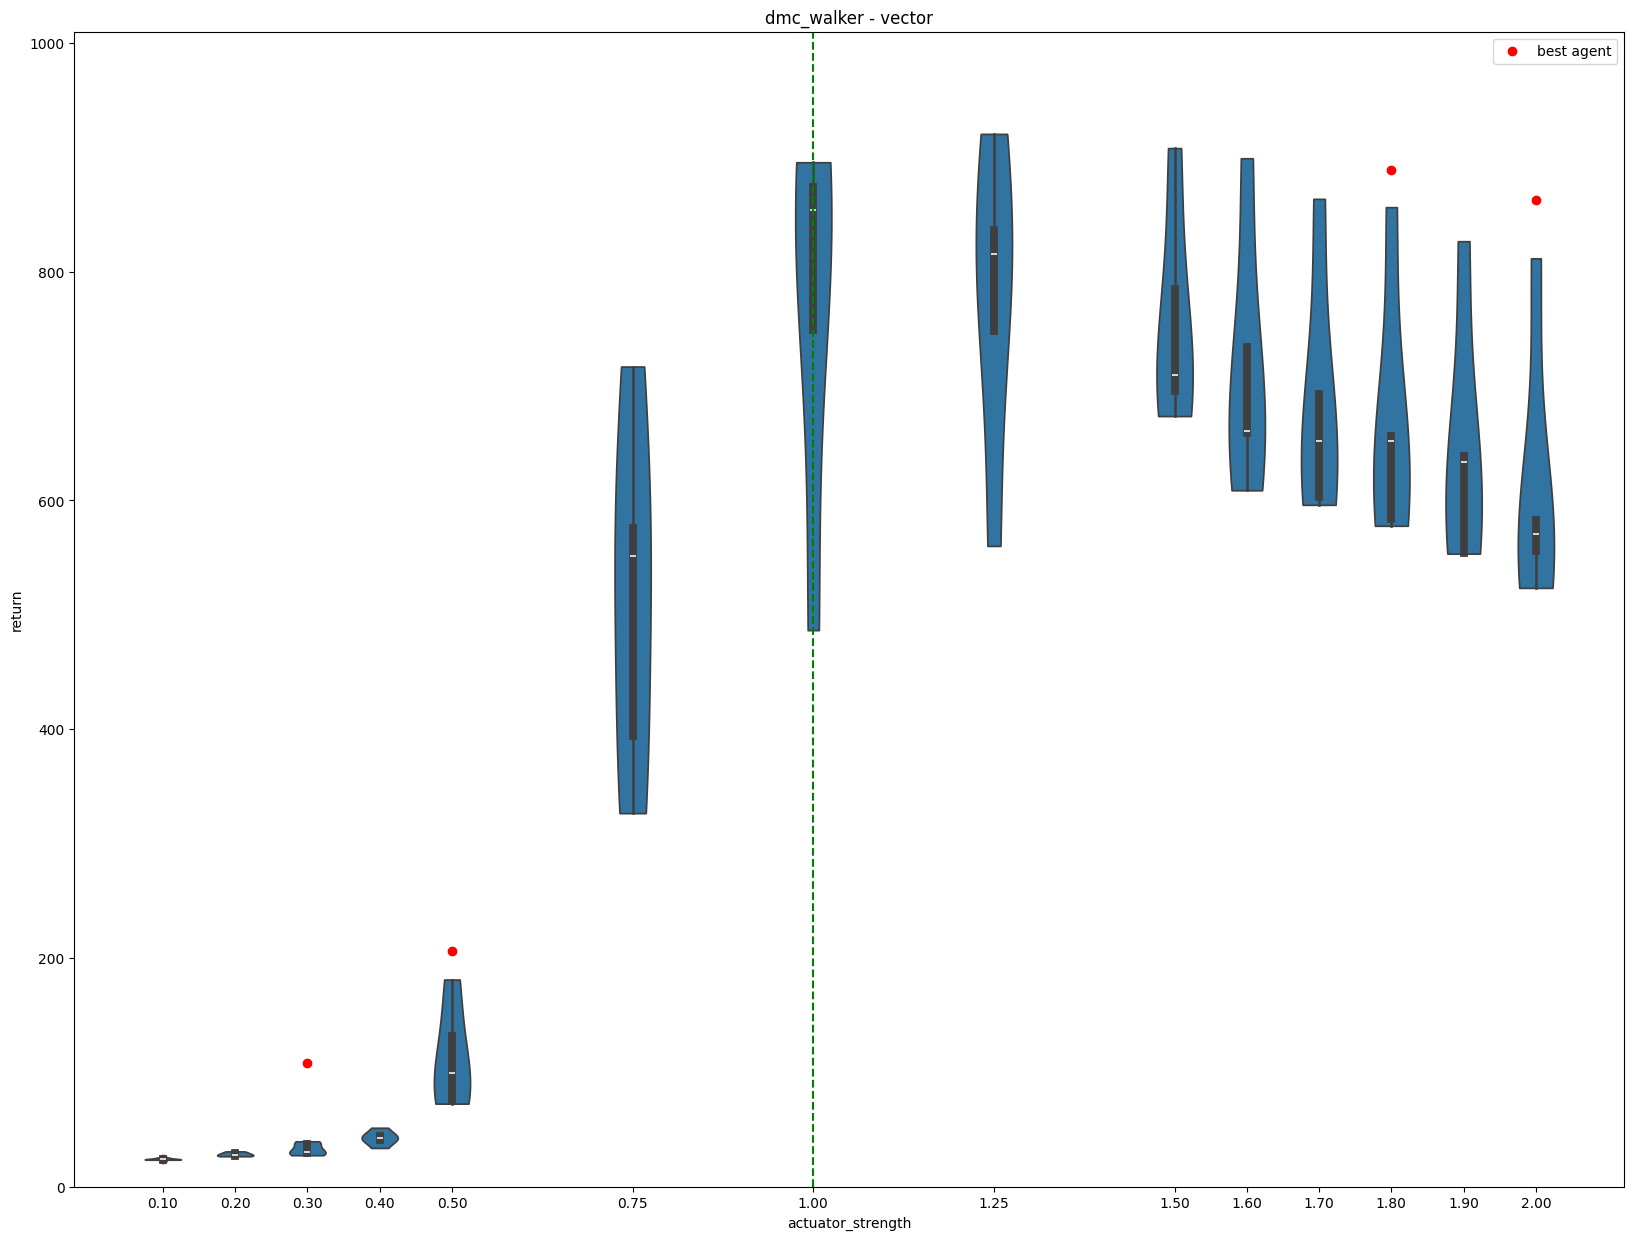

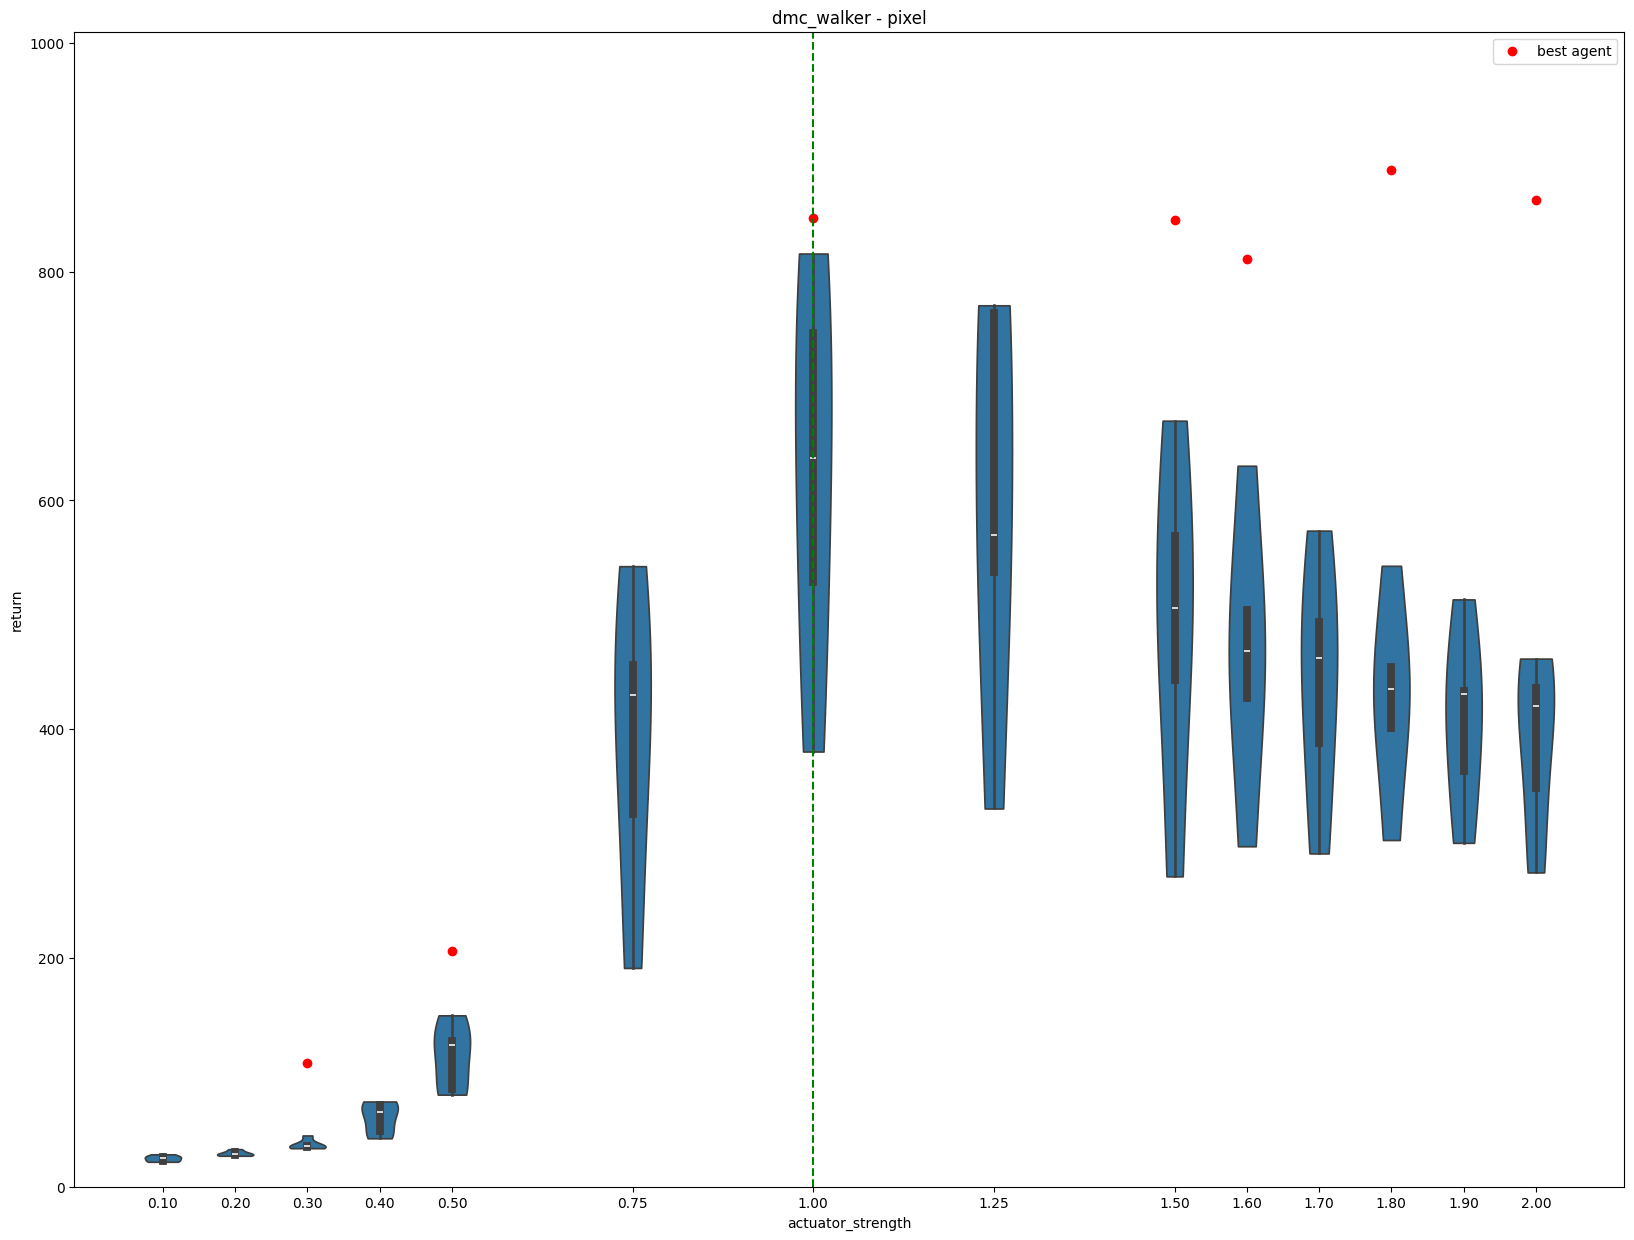

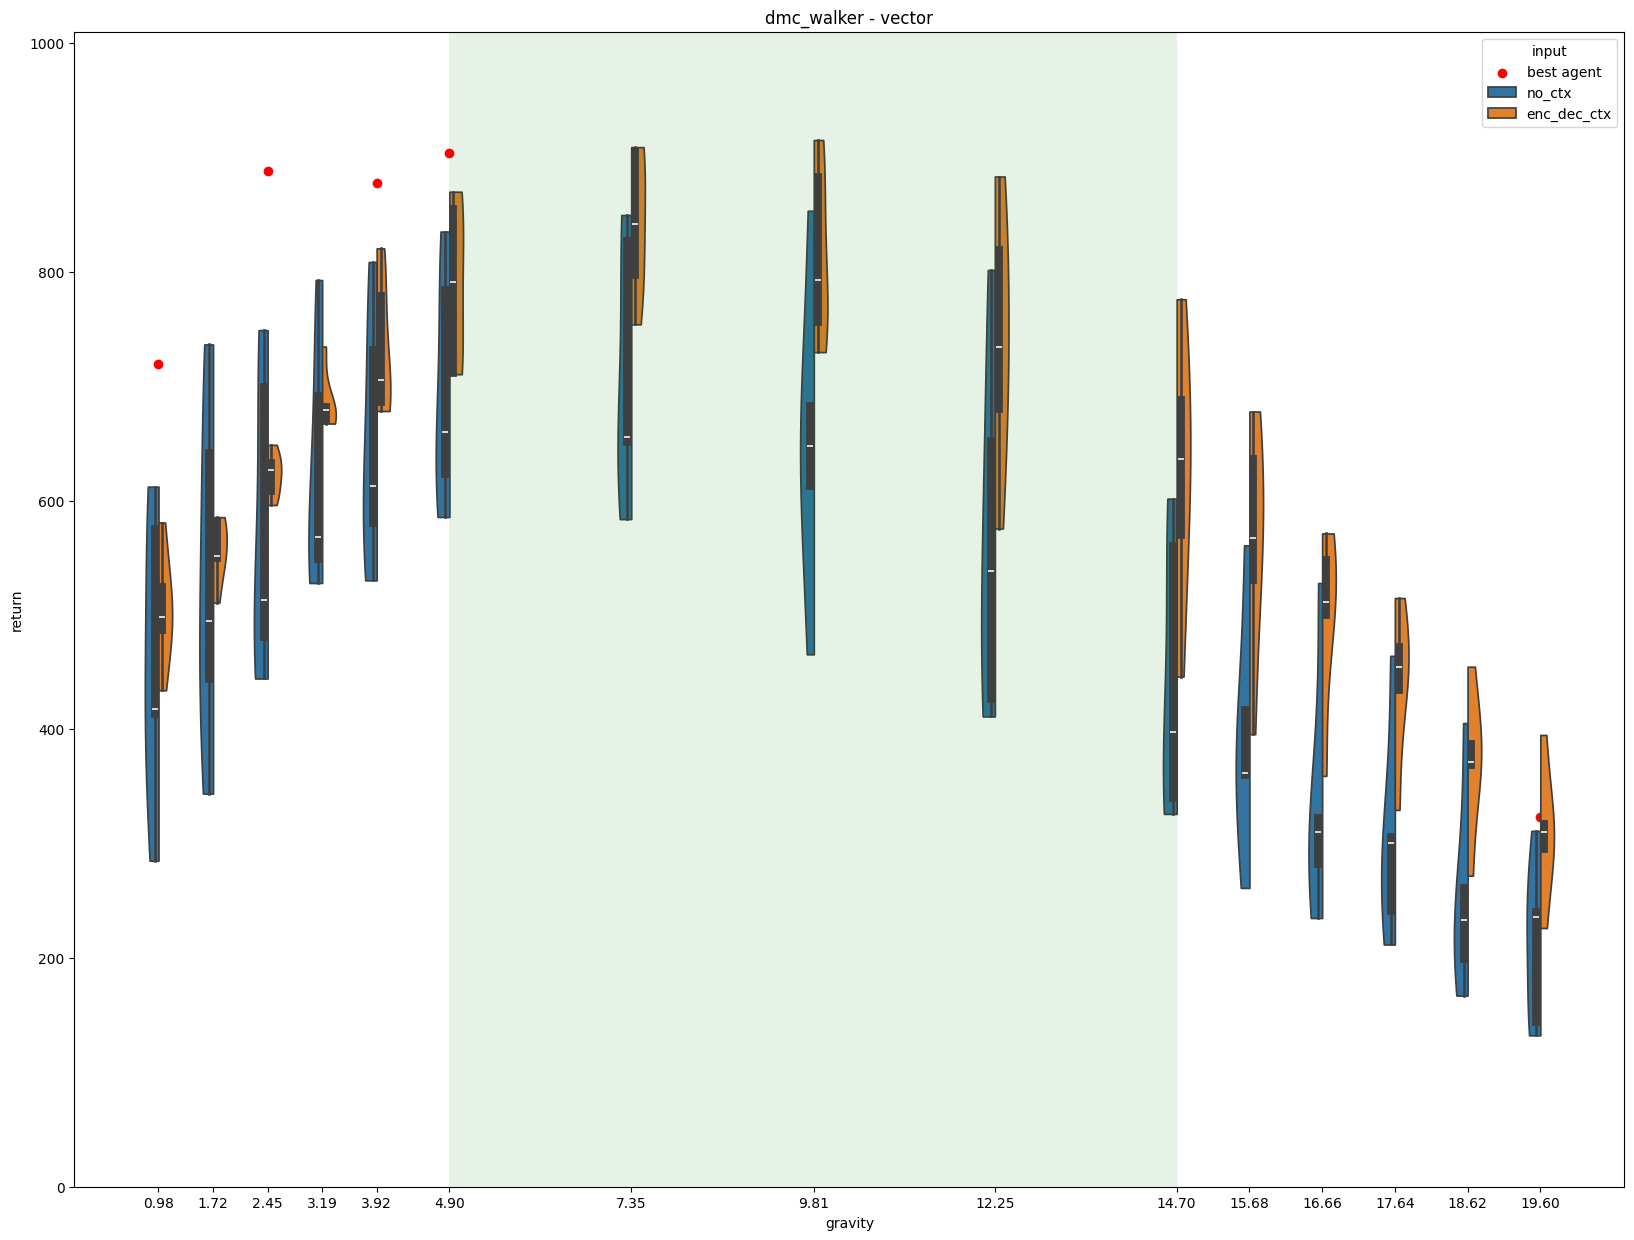

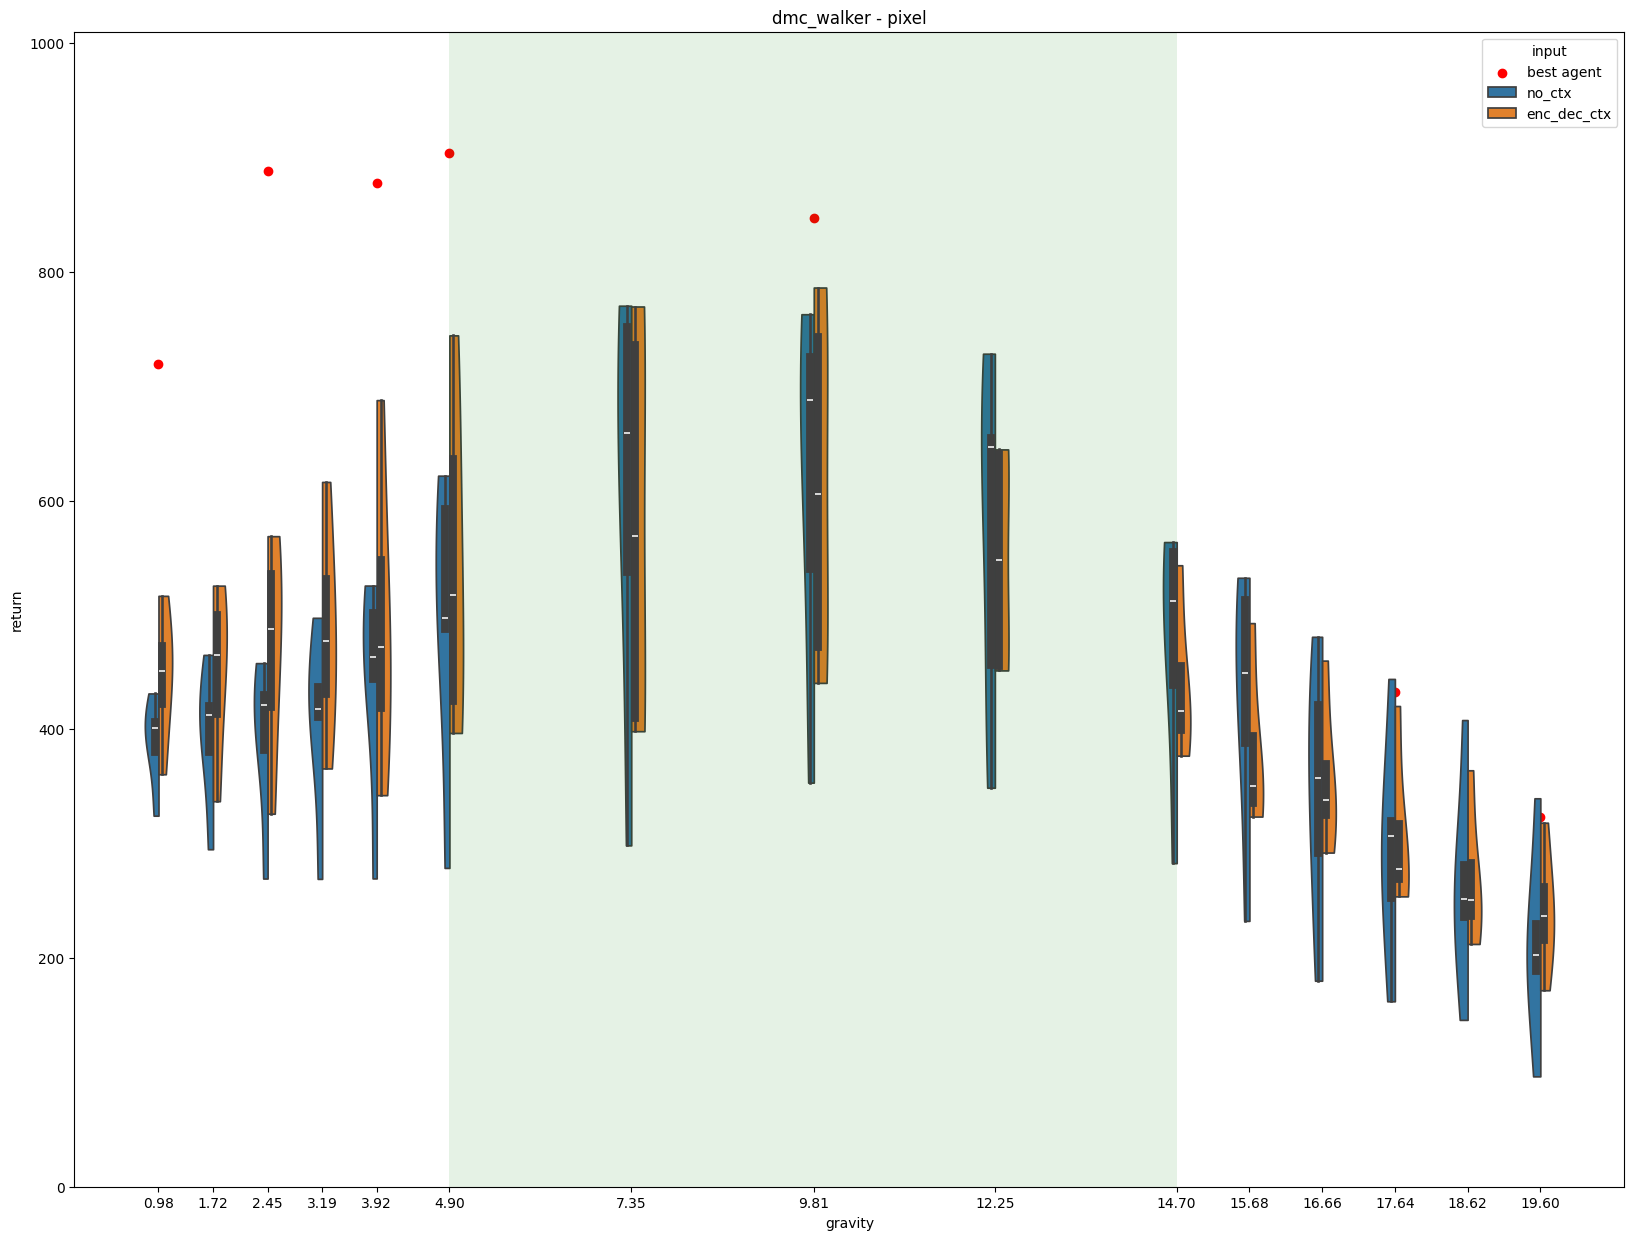

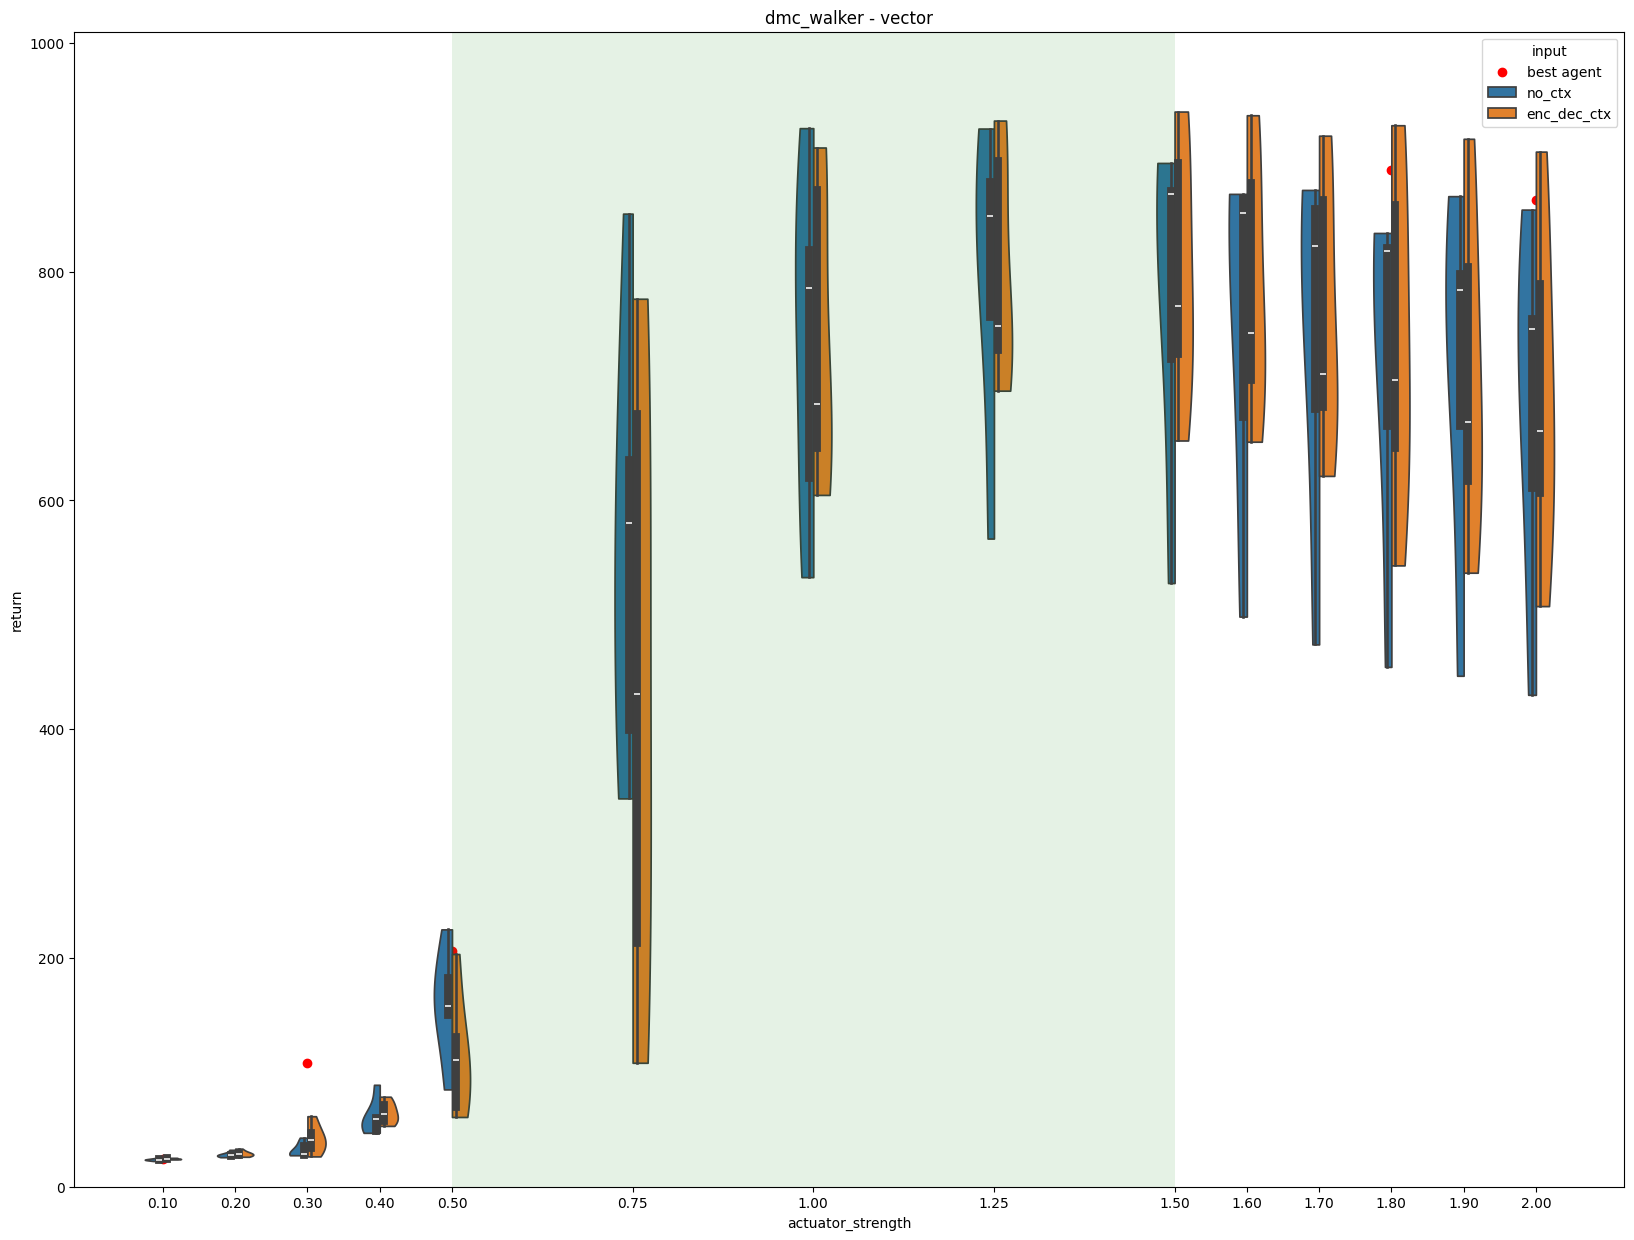

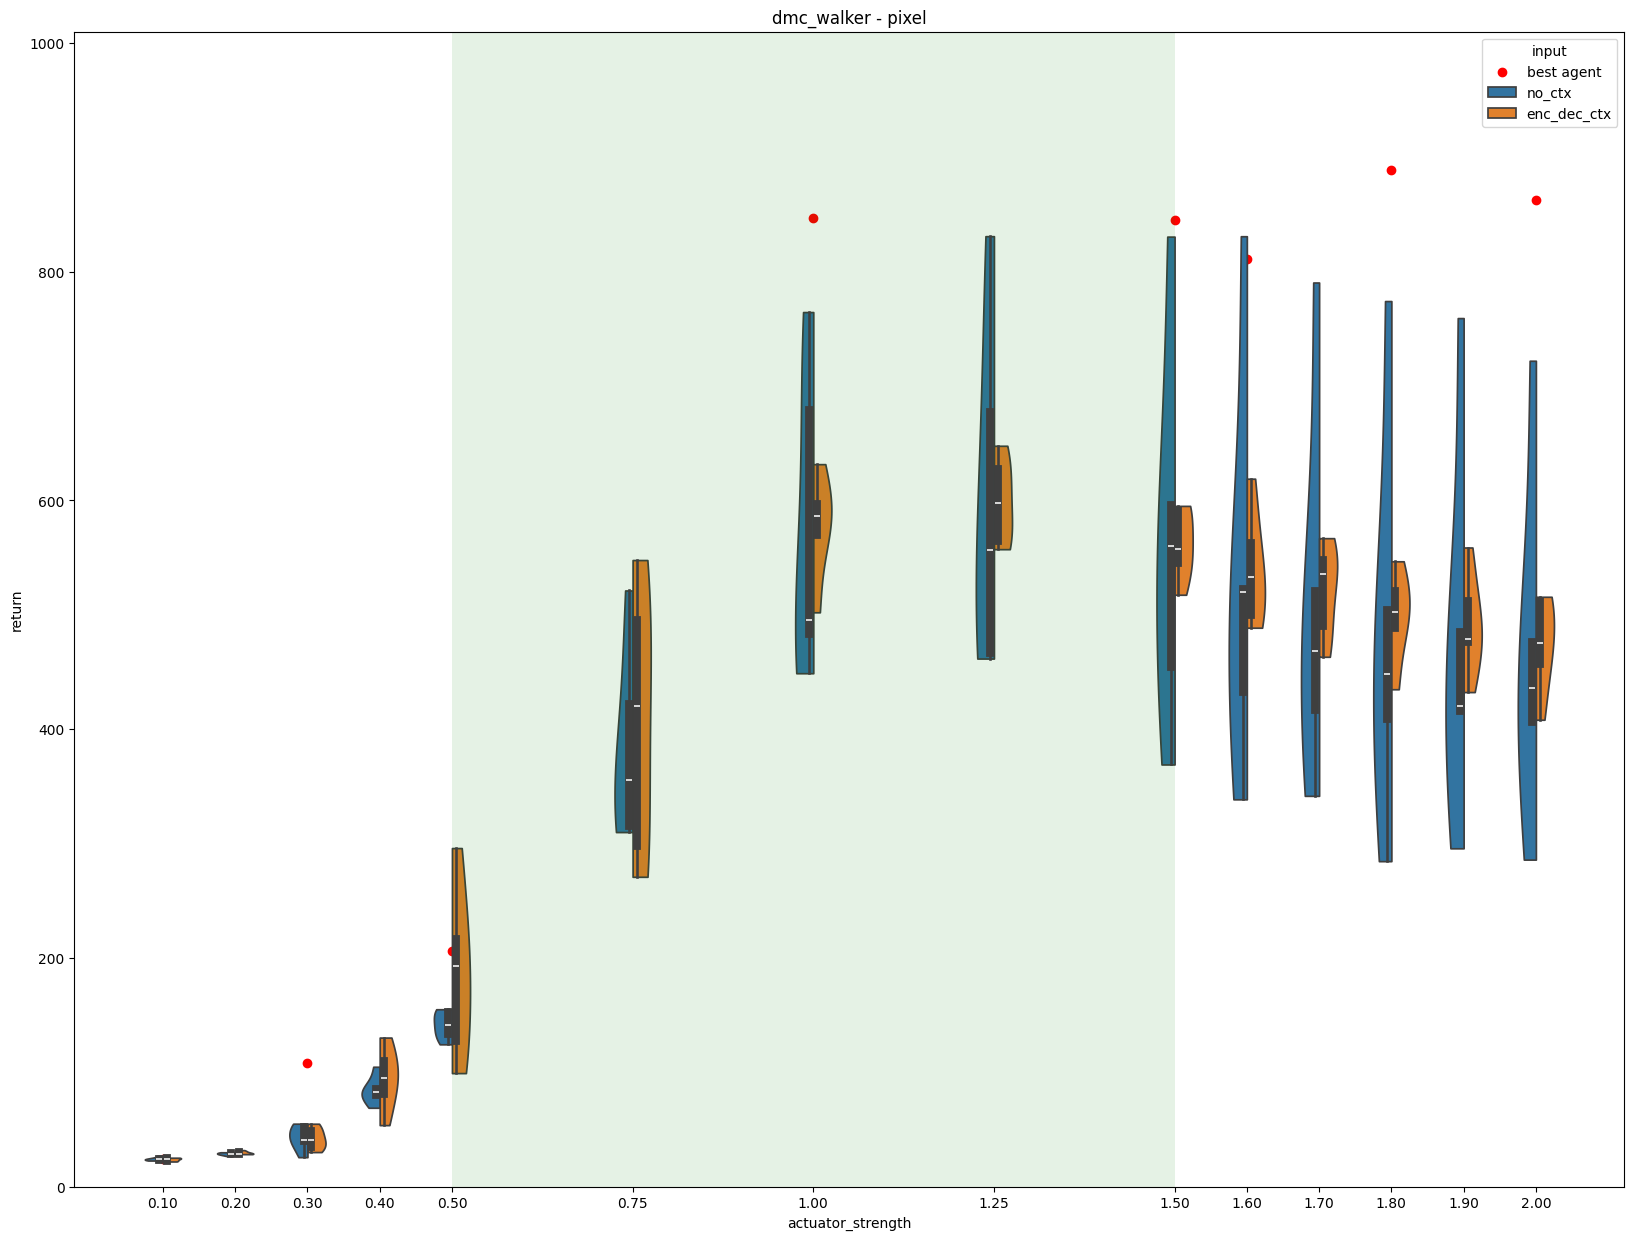

In [71]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
    for train_setting in train_settings:
        for context_id in context_ids:
            for modality in modalities:

                decode_ctx = [False]     
                for only_decode_ctx in decode_ctx:
                    plot_violin_plots(task, train_setting, context_id, modality, save_dir, logdir, only_decode_ctx, best_agent_metrics, "normalized")

In [75]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np


def compute_regret_single(task, train_setting, context_idx, modality, ctx_type, log_dir, save_dir, best_agent_metrics, t_step="50k"):
    train_setting_full = "default" if train_setting == "default" else f"{train_setting}_{context_idx}"
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
    else:
        raise RuntimeError("invalid ctx")

    modality = "vector" if modality == "obs" else "pixel"
        
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
        
    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            if context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0:
                ctx_value = line['ctx']["context"][context_name]
                ret = float(line['return'])
                ctx_val = [default_0, default_1]
                ctx_val[context_idx] = ctx_value
                current_metrics[(ctx_val[0], ctx_val[1])].append(ret)
    best_metrics = best_agent_metrics[task]
    
    regret = {}
    for current_key in current_metrics:
        current_value = np.mean(current_metrics[current_key])
        best_keys = list(best_metrics.keys())
        distances = cdist([current_key], best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        # print(current_key, nearest_key)
        nearest_best_value = np.mean(best_metrics[nearest_key])
        regret[current_key] = nearest_best_value - current_value
    # print("regret", regret)
    if train_setting == "default":
        default_val = [default_0, default_1][context_idx]
        interpolate_range = [default_val, default_val + 1e-6]
    else:
        interpolate_range = _TASK2CONTEXTS[task][context_idx]["train_range"]
    save_path = save_dir / f"{task}_{context_name}_{train_setting}_{modality}.json"
    interpolate_regret = []
    extrapolate_regret = []
    for ctx_key in regret:
        if ctx_key[context_idx] >= interpolate_range[0] and ctx_key[context_idx] <= interpolate_range[1]:
            interpolate_regret.append(regret[ctx_key])
        else:
            extrapolate_regret.append(regret[ctx_key])
    print("setting", task, train_setting, context_name, modality, ctx_type)
    print("mean interpolate_regret", np.mean(interpolate_regret))
    print("mean extrapolate regret", np.mean(extrapolate_regret))
    print("mean regret", np.mean(interpolate_regret + extrapolate_regret))
    print("--------------------------------------------")

In [76]:

tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
    for train_setting in train_settings:
        for context_id in context_ids:
            for modality in modalities:
                if train_setting == "default":
                    ctx_types = ["no_ctx"]
                else:
                    ctx_types = ["no_ctx", "enc_dec_ctx"]
                
                for ctx_type in ctx_types:
                    compute_regret_single(task, train_setting, context_id, modality, ctx_type, logdir, save_dir, best_agent_metrics, "normalized")


setting classic_cartpole default gravity vector no_ctx
mean interpolate_regret 0.0
mean extrapolate regret -1.2329120879120816
mean regret -1.1507179487179429
--------------------------------------------
setting classic_cartpole default gravity pixel no_ctx
mean interpolate_regret 0.33076923076924913
mean extrapolate regret 63.94699999999999
mean regret 59.705917948717946
--------------------------------------------
setting classic_cartpole default length vector no_ctx
mean interpolate_regret 0.0
mean extrapolate regret 29.45472537417335
mean regret 27.35081641887525
--------------------------------------------
setting classic_cartpole default length pixel no_ctx
mean interpolate_regret 0.33076923076924913
mean extrapolate regret 395.88441861004753
mean regret 367.63058651152767
--------------------------------------------
setting classic_cartpole single gravity vector no_ctx
mean interpolate_regret -0.34076923076924004
mean extrapolate regret -0.770123076923079
mean regret -0.62700512

In [25]:
import json
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import sem
from pathlib import Path
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle


def plot2d(logdir, save_dir, task, modality, train_mode, ctx, exp_suffix):


    data = defaultdict(list)


    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]

    if train_mode == "default":
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        interpolate_range_0 = [default_0, default_0]
        interpolate_range_1 = [default_1, default_1]
    else:
        interpolate_range_0 = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_range_1 = _TASK2CONTEXTS[task][1]["train_range"]

    if ctx == "no_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_{exp_suffix}"
    elif ctx == "enc_dec_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_ctx_{exp_suffix}"
    elif ctx == "enc_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_{exp_suffix}"
    else:
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_ctx_{exp_suffix}"
    modality = "vector" if modality == "obs" else "pixel"
    seeds = 0
    experiment = exp_path.name
    for seed_path in exp_path.iterdir():
        seed = int(seed_path.name)
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        seeds += 1
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            
            ctx_0_value = line['ctx']["context"][ctx_0]
            ctx_1_value = line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            data[(ctx_0_value, ctx_1_value)].append(ret)


    x = []
    y = []
    c = []
    for ctx_0_value, ctx_1_value in data:
        x.append(ctx_0_value)
        y.append(ctx_1_value)
        c.append(np.mean(data[(ctx_0_value, ctx_1_value)]))


    df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
    df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
    
    # sort the rows descending
    df = df.sort_index(ascending=False)

    
    # darker colors for higher values, red color map
    ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f")
    

    h_index_0 = df.index.searchsorted(interpolate_range_0[0], 'left', df.index.argsort())
    h_index_1 = df.index.searchsorted(interpolate_range_0[1], 'right', df.index.argsort())

    v_index_0 = df.columns.searchsorted(interpolate_range_1[0], 'left')
    v_index_1 = df.columns.searchsorted(interpolate_range_1[1], 'right')
    
    ax.add_patch(Rectangle((v_index_0, h_index_0), (v_index_1 - v_index_0), (h_index_1 - h_index_0), fill=False, edgecolor='g', linestyle='--', linewidth=2))
    plt.title(f"{task} - {modality} - {ctx}")
    
    plt.savefig(save_dir / f"{task}_{train_mode}_{modality}_{ctx}.pdf")
    
    if seeds != 5:
        print(f"not enough seeds - {task} - {modality} - {ctx} - {seeds}")
    
    # clear plt
    plt.pause(0.1)
    return df

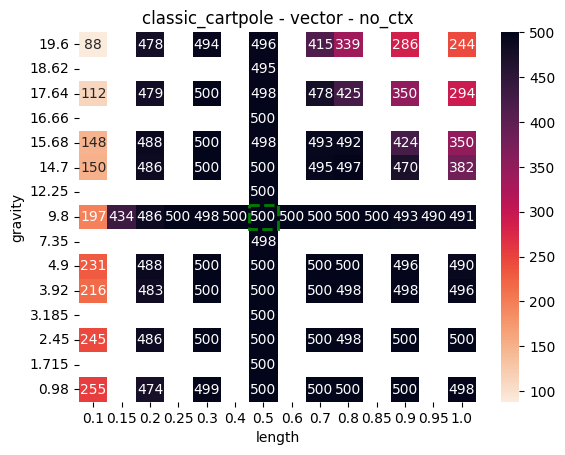

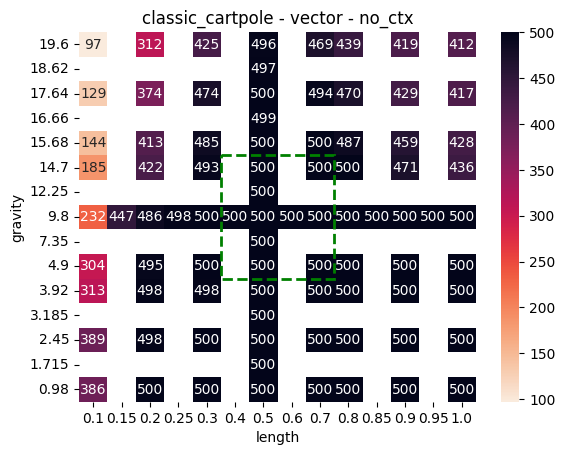

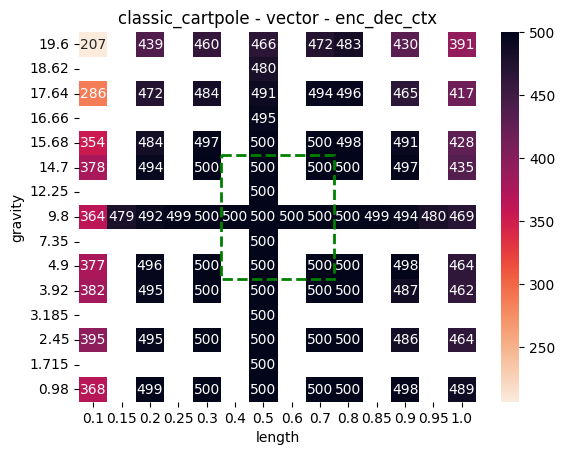

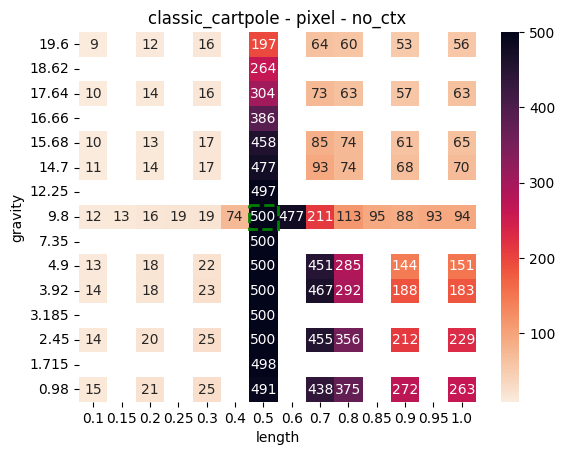

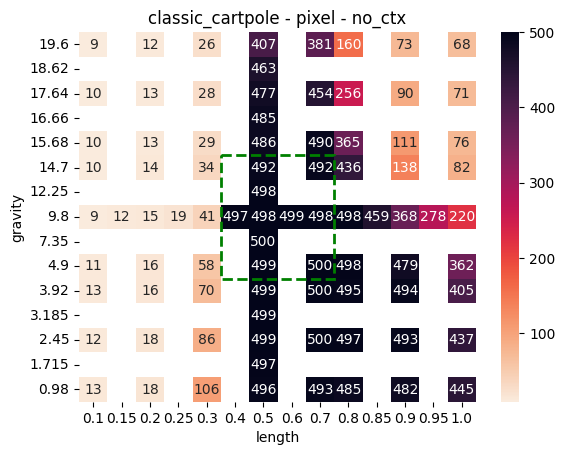

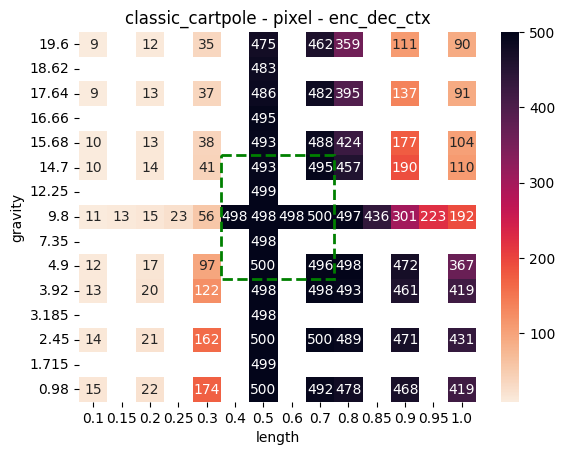

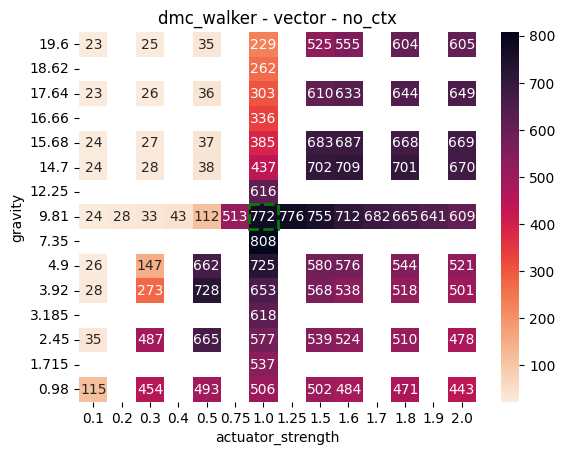

not enough seeds - dmc_walker - vector - no_ctx - 4


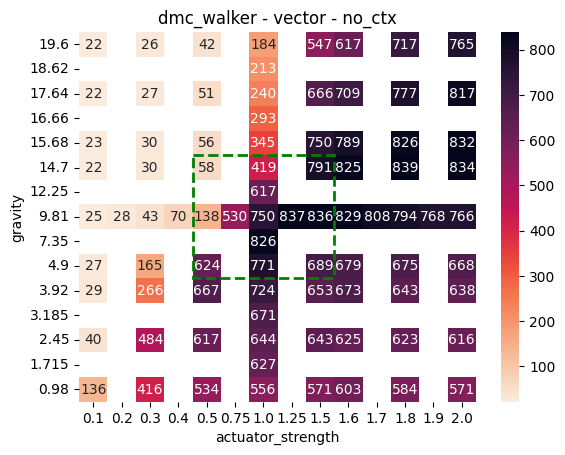

not enough seeds - dmc_walker - vector - enc_dec_ctx - 4


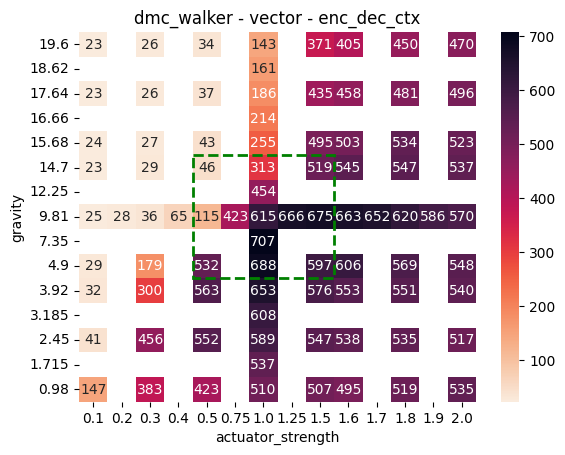

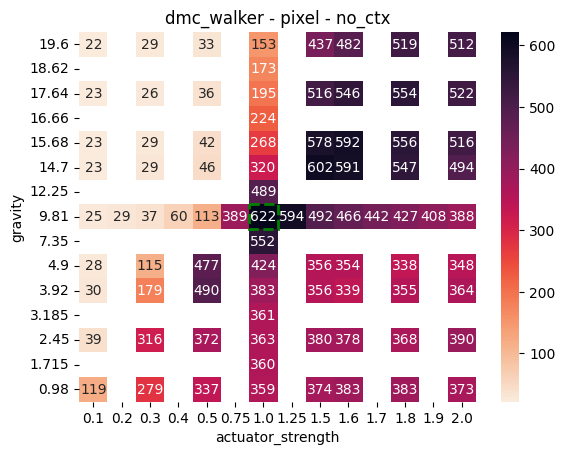

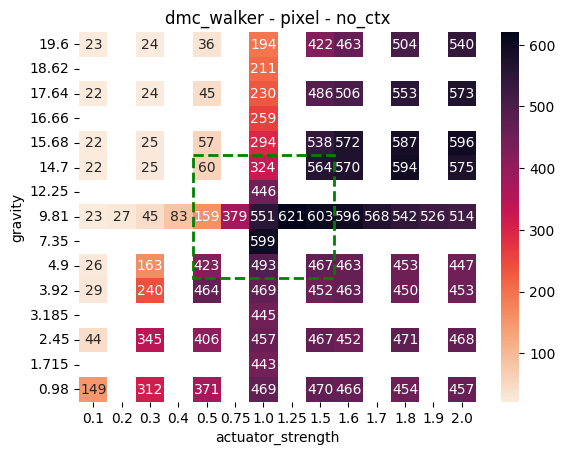

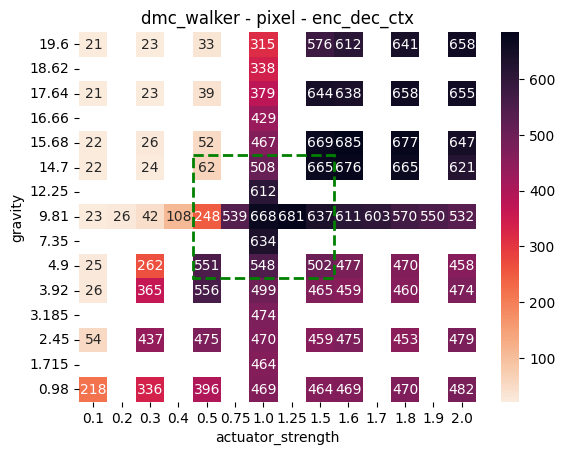

In [26]:
exp_suffix = "normalized"
tasks = ["classic_cartpole", "dmc_walker"]
modalities = ["obs", "img"]
train_modes = ["default", "double_box"]
logdir = Path("../logs") 

save_dir = Path("./plots/")
for task in tasks:
    for modality in modalities:
        for train_mode in train_modes:
            plot2d(logdir, save_dir, task, modality, train_mode, "no_ctx", exp_suffix)
            if train_mode == "double_box":
                plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", exp_suffix)                


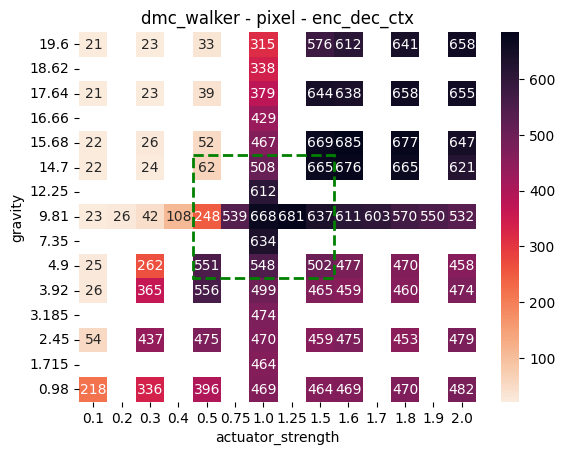

In [23]:
df = plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", exp_suffix)